# Super restriction factor hypermutation analysis
### Adam S. Dingens
### In collabortation with Mollie McDonnell and Michael Emerman

Analysis performed by Adam Dingens in the [Bloom lab](http://research.fhcrc.org/bloom/en.html) in early 2019. Cell culture experiments performed by Mollie McDonnell, and sequencing prep performed by Mollie with Adam's guidance.

Bcinfo csv analysis performed by Kate Dusenbury late 2019.

## Import `Python` modules, define widely used functions
Set `use_existing` to `yes` below if you want to use any existing output, and `no` if you want to re-generate all output.

In [2]:
import os
import glob
%matplotlib inline
import pandas as pd
from IPython.display import display, HTML
import dms_tools2
import dms_tools2.plot
import dms_tools2.sra
import dms_tools2.utils
import dms_tools2.diffsel
import dms_tools2.prefs
from dms_tools2.ipython_utils import showPDF
import string
import Bio.SeqIO
import Bio.Seq
import Bio.SeqRecord
import numpy as np
import pylab as plt

from plotnine import *

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))


# results will go in this directory
resultsdir = './results_1and1b/' 
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# CPUs to use, -1 means all available
ncpus = 14

# do we use existing results or generate everything new?
use_existing = "yes"

Using dms_tools2 version 2.6.4


In [3]:
from dms_tools2.utils import barcodeInfoToCodonVariantTable
from dms_tools2.utils import getSubstitutions
import re
import tempfile
import dms_variants.codonvarianttable
import gzip

# Download the sequencing data from the Sequence Read Archive
UPDATE LATER

samples = pd.DataFrame.from_records(
#new data published here for 1-18
        [('BG505_mut_virus_rep3d_1-18-4ug','SRR10014244'),
         ('BG505_mut_virus_rep3d_1-18-8ug','SRR10014243'),
         ('BG505_mut_virus_rep2d_1-18-4ug','SRR10014242'),
         ('BG505_mut_virus_rep2d_1-18-8ug','SRR10014241'),
         ('BG505_mut_virus_rep2d','SRR10014240'),
         ('BG505_mut_virus_rep3d','SRR10014239'),
#Data on VRC01 and 3BNC117 from Dingens et al Immunity 2019 
#Here, I do not download the data on 10-1074 and pooled 10-1074/3BNC117. While I look at this data briefly for one analysis, I simply download the analyzed files from github rather than redoing all analyses. However these can be downloaded and anaylzed in parallel by uncommentin the relevant lines below. 
         ('BG505_mut-virus-rep1b','SRR7693968'),
         ('BG505_mut-virus-rep2b-3BNC117-4ug','SRR7693969'),
         ('BG505_mut-virus-rep1-VRC01-11ug','SRR7693971'),

         ('BG505_mut-virus-rep3','SRR7693976'),
         ('BG505_mut-virus-rep3-3BNC117-1-1ug','SRR7693977'),
         ('BG505_mut-DNA-rep1','SRR7693986'),
         ('BG505_mut-DNA-rep3','SRR7694021'),
         ('BG505_mut-virus-rep2b','SRR7694018'),
         ('BG505_wt-DNA-rep3','SRR7694017'),
         ('BG505_mut-virus-rep2-VRC01-8ug','SRR7694015'),

         ('BG505_mut-virus-rep1b-3BNC117-4ug','SRR7694006'),
         ('BG505_mut-virus-rep3b-3BNC117-4ug','SRR7694005'),
         ('BG505_mut-virus-rep3b','SRR7694003'),
         ('BG505_mut-DNA-rep2','SRR7694002'),
         ('BG505_wt-DNA-rep2','SRR7693998'),
         ('BG505_mut-virus-rep2','SRR7693997'),
         ('BG505_mut-virus-rep3-VRC01-tr2-11ug','SRR7693996'),
         ('BG505_mut-virus-rep3-VRC01-11ug','SRR7693992'),
         ('BG505_mut-virus-rep2-VRC01-11ug','SRR7693991'),
         ('BG505_mut-virus-rep2b-3BNC117-3ug','SRR7693990'),
         ('BG505_wt-DNA-rep1','SRR7693989'),
         ('BG505_mut-virus-rep1','SRR7693987')],
        columns=['name', 'run']
        )


fastqdir = './results/FASTQ_files/'
if not os.path.isdir(fastqdir):
    os.mkdir(fastqdir)
print("Downloading FASTQ files from the SRA...")
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump', # valid path to this program on the Hutch server
        fastqdir=fastqdir,
        aspera=(
            '/app/aspera-connect/3.5.1/bin/ascp', # valid path to ascp on Hutch server
            '/app/aspera-connect/3.5.1/etc/asperaweb_id_dsa.openssh' # Aspera key on Hutch server
            ),
        )
print("Here are the names of the downloaded files now found in {0}".format(fastqdir))
display(HTML(samples.to_html(index=False)))

## Define samples from FASTQ_files

R1fastqfilelist_df = pd.read_csv("./data/samples.csv", header =0)
display(HTML(R1fastqfilelist_df.to_html(index=False)))

In [4]:
samplenames = ["PLASMIDCTRL", "NoA3_1", "A3G_1", "A3C_1", "A3CE68A_1", "COTD_1", "COTDE254A_1", "COTDE68AE254A_1", "I188_1", "I188E68A_1", "COII_1", "COIIE68AE254A_1", "NoA3_2", "A3G_2", "A3C_2", "A3CE68A_2", "COTD_2", "COTDE254A_2", "COTDE68AE254A_2", "I188_2", "I188E68A_2", "COII_2", "COIIE68AE254A_2"]
R1_df = pd.DataFrame({'name':samplenames})

R1_df["name"] = R1_df['name'].str.replace("_", "-")
R1_df["R1"] = R1_df['name'].astype(str) + "_R1.fastq.gz"
print(R1_df)

               name                           R1
0       PLASMIDCTRL      PLASMIDCTRL_R1.fastq.gz
1            NoA3-1           NoA3-1_R1.fastq.gz
2             A3G-1            A3G-1_R1.fastq.gz
3             A3C-1            A3C-1_R1.fastq.gz
4         A3CE68A-1        A3CE68A-1_R1.fastq.gz
5            COTD-1           COTD-1_R1.fastq.gz
6       COTDE254A-1      COTDE254A-1_R1.fastq.gz
7   COTDE68AE254A-1  COTDE68AE254A-1_R1.fastq.gz
8            I188-1           I188-1_R1.fastq.gz
9        I188E68A-1       I188E68A-1_R1.fastq.gz
10           COII-1           COII-1_R1.fastq.gz
11  COIIE68AE254A-1  COIIE68AE254A-1_R1.fastq.gz
12           NoA3-2           NoA3-2_R1.fastq.gz
13            A3G-2            A3G-2_R1.fastq.gz
14            A3C-2            A3C-2_R1.fastq.gz
15        A3CE68A-2        A3CE68A-2_R1.fastq.gz
16           COTD-2           COTD-2_R1.fastq.gz
17      COTDE254A-2      COTDE254A-2_R1.fastq.gz
18  COTDE68AE254A-2  COTDE68AE254A-2_R1.fastq.gz
19           I188-2 

## Process the FASTQ files to count the mutations for each sample
We used [barcoded-subamplicon](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) sequencing to obtain high accuracy during the Illumina deep sequencing. We therefore use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp) program to analyze these data.

Running that program requires specifying a `--batchfile` that lists the samples, a wildtype `--refseq` to which we make alignments, and --alignspecs that tell us where the subamplicons should align. 
The batch file that we specify is printed by the cell below. The alignment specs need to be exactly correct for the subamplicons to align. We also do some trimming of the reads using the `--R1trim` and `--R2trim` parameters. 

The wildtype sequence of the BG505.W6.C2.T332N Env used in this experiment is in the file [./data/BG505.W6.C2.T332N_env.fasta](./data/BG505.W6.C2.T332N_env.fasta).
This sequence is based on GenBank accession number [DQ208458.1](https://www.ncbi.nlm.nih.gov/nucleotide/77025198?report=genbank&log$=nuclalign&blast_rank=1&RID=WMZ5XNUG014), with the introduced T332N mutation to knock in the glycan commonly targeted by this class of bnAbs. 

In [5]:
!pwd


/fh/fast/bloom_j/computational_notebooks/kdusenbu/2019/SuperRFs/SuperRestrictionFactor_Hypermutation


In [6]:
#first, initial fastqdir ='../../../../SR/ngs/illumina/bloom_lab/190913_M03100_0478_000000000-CKT45/Data/Intensities/'
#these are in: "./FASTQ_files_initialMiseqOnly/"

#then the post rnd2 samples were repooled and sequenced again. These additional reads can thus simple be added to the existing reads. I did this by concatenating all reads from both runs into single fastq files, putting them in the same fastq file
#second miseq to be added with initial miseq run. These are in:
fastqdir = "./FASTQ_files/"


#Mollie also redid rnd2? and resquenced. These read CANNOT be added to the above reads before error correction, as molecules were tagged in spereate PCR rxns?
#however, in the future, the error corrected mutation counts could be summed together and then analyzed. 
#For now, I put these reads in a seperate fastqdir:
#miseq run: 191104_M04866_0302_000000000-CNB5P
#these are in: "./FASTQ_files_exp2/"


In [7]:
refseq = './data/Bru_Pol.fasta'

# define subamplicon alignment specifications
alignspecs = ' '.join(['205,504,35,34']) #was 204,504,34,34 #these need to be updated 179,529,25,25


# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(R1_df[['name', 'R1']].to_html(index=False)))
R1_df[['name', 'R1']].to_csv(countsbatchfile, index=False)

#we will only look at sites sequenced
sitemaskfile = "./data/sitemask.csv"

Here is the batch file that we write to CSV format to use as input:


name,R1
PLASMIDCTRL,PLASMIDCTRL_R1.fastq.gz
NoA3-1,NoA3-1_R1.fastq.gz
A3G-1,A3G-1_R1.fastq.gz
A3C-1,A3C-1_R1.fastq.gz
A3CE68A-1,A3CE68A-1_R1.fastq.gz
COTD-1,COTD-1_R1.fastq.gz
COTDE254A-1,COTDE254A-1_R1.fastq.gz
COTDE68AE254A-1,COTDE68AE254A-1_R1.fastq.gz
I188-1,I188-1_R1.fastq.gz
I188E68A-1,I188E68A-1_R1.fastq.gz


In [8]:

#here, we need to allow for a large number of mismatches if the sequence was in fact hypermutated

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 170 \
        --minq 15 \
        --fastqdir {fastqdir} \
        --maxmuts 100 \
        --sitemask {sitemaskfile} \
        --ncpus {ncpus} \
        --bcinfo \
        --bcinfo_csv \
        --use_existing {use_existing} 
print("Completed dms2_batch_bcsubamp.")

# need to edit



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


Now we look at the summary plots created by `dms2_batch_bcsubamp`. 
All of these files are found in the directory specified by --outdir, and with the prefix specified by summaryprefix. 
So we define them using this plot prefix plus the suffix for each plot.
Note that these files all refer to sites in sequential 1, 2, ... numbering of the BF520 sequence.

In [9]:
countsplotprefix = os.path.join(countsdir, 'summary')

The `*_readstats.pdf` plot below shows the statistics on the reads. This plot shows that most of the reads were retained, and a small fraction discarded because of low-quality barcodes. None failed the Illumina filter as those were already filtered out those when we downloaded from the SRA.

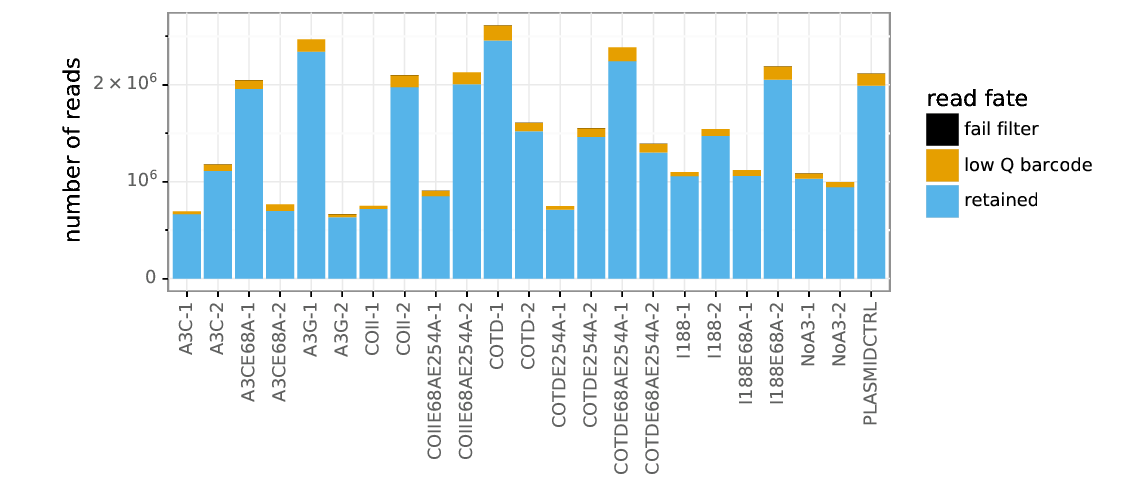

In [10]:
showPDF(countsplotprefix + '_readstats.pdf', width=600)

The `*_readsperbc.pdf` plot below shows how many times different barcodes were observed for each sample. Barcodes need to be observed multiple times to be useful for barcoded-subamplicon sequencing error correction.

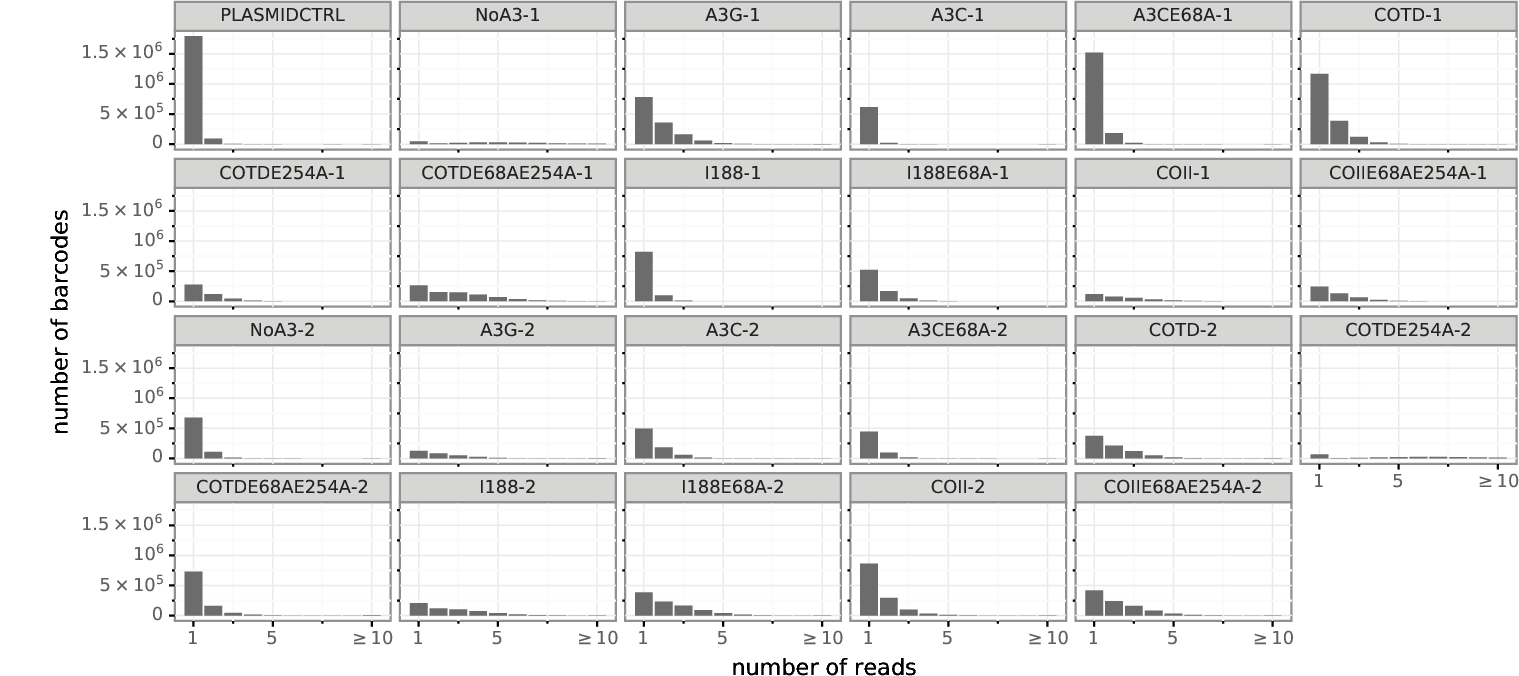

In [11]:
showPDF(countsplotprefix + '_readsperbc.pdf')

The `*_bcstats.pdf` plot below shows statistics on the barcodes. Some of the barcodes had to be discarded because they had too few reads (these are the single-read barcodes in the plot above), a small fraction with adequate reads were not alignable, and the rest aligned to the Env gene properly.
This plot and the one above suggest that probably could have gotten additional depth by sequencing more, since then we would have had more barcodes with multiple reads.

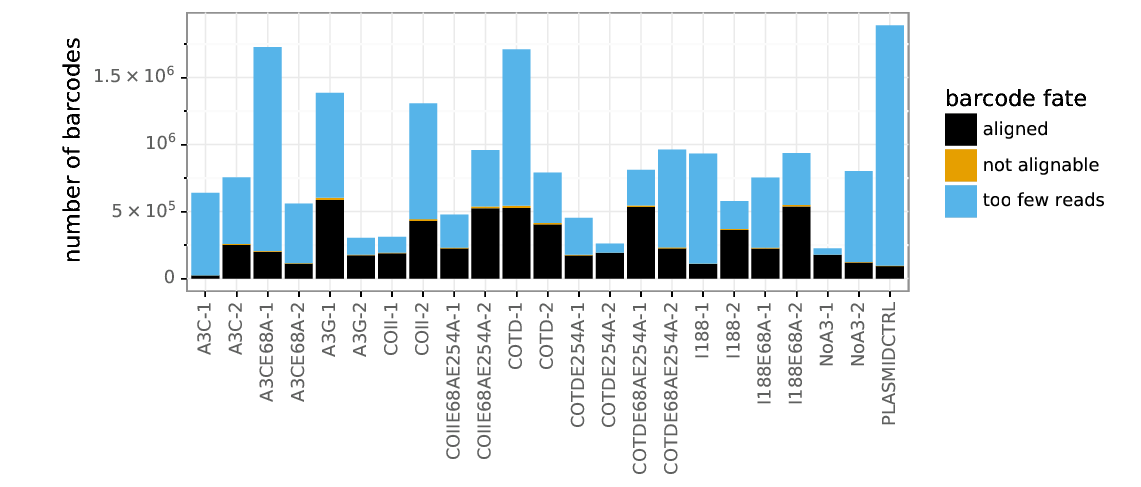

In [12]:
showPDF(countsplotprefix + '_bcstats.pdf', width=600)

The `*_depth.pdf` plot below shows the depth (number of called codons) at each site in the gene. 
For most of the samples, the depth across the gene is fairly uniform, indicating that the subamplicons were pooled fairly evenly.  
Note that some samples (in particular the mock samples) were intentionally sequenced to higher depth than the antibody-selected samples, as we expect to see more diversity in the mock samples. 
Note that the gene was not sequenced past codon site 691, and so there is no coverage there.

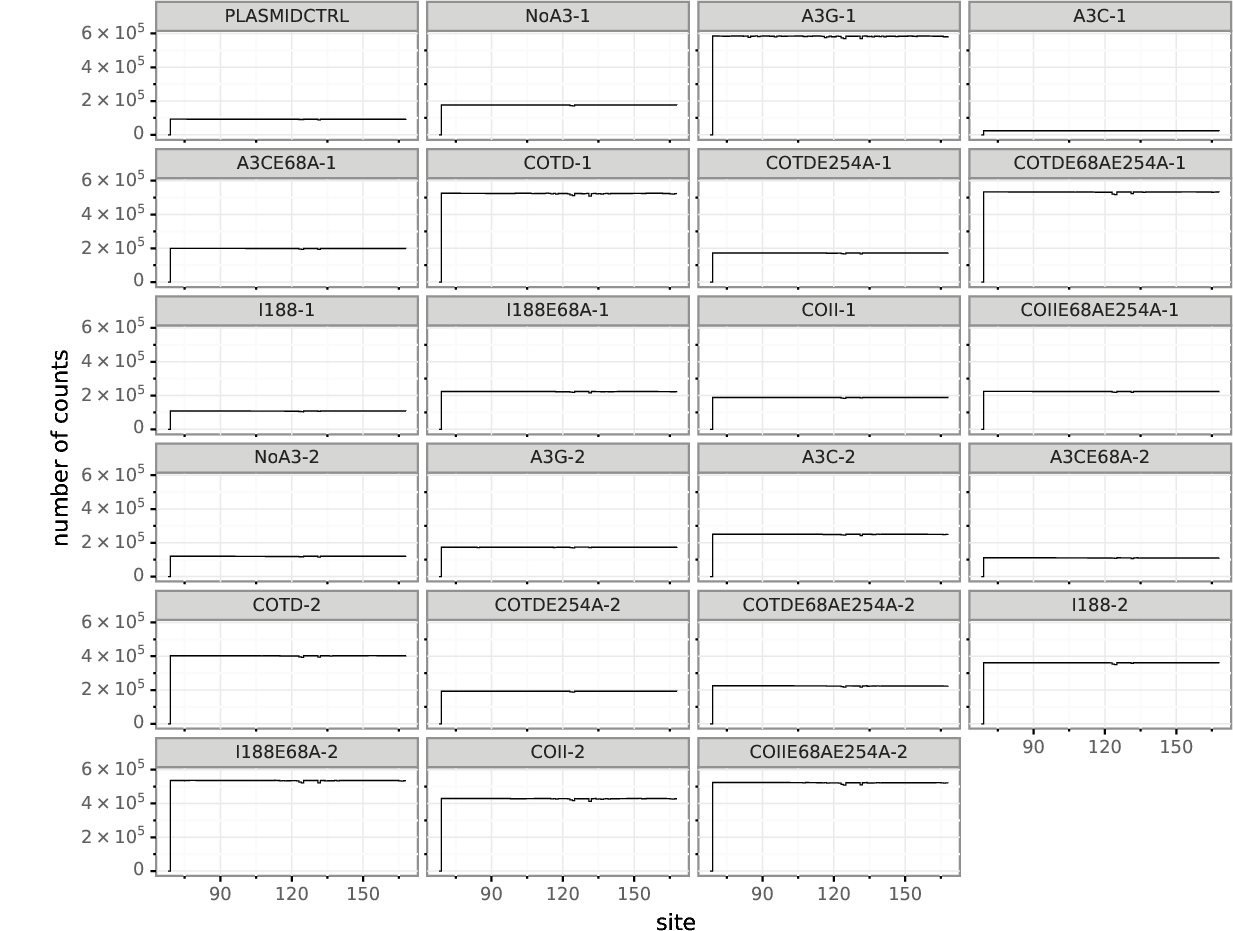

In [13]:
showPDF(countsplotprefix + '_depth.pdf')

The `*_mutfreq.pdf` plot below shows the per-codon frequency of mutations at each site. 
For each antibody-selected sample, we see a few sites of clear peaks in mutation frequency. 
These peaks tend to occur at the same sites in different replicates, and so presumably represent the sites where antibody-escape mutations are selected. 
There are no such peaks for the mock sample since there is no antibody selection to favor specific mutations.
Note also that the gene was not mutagenized or sequenced past codon site 691, so there are no mutations there.

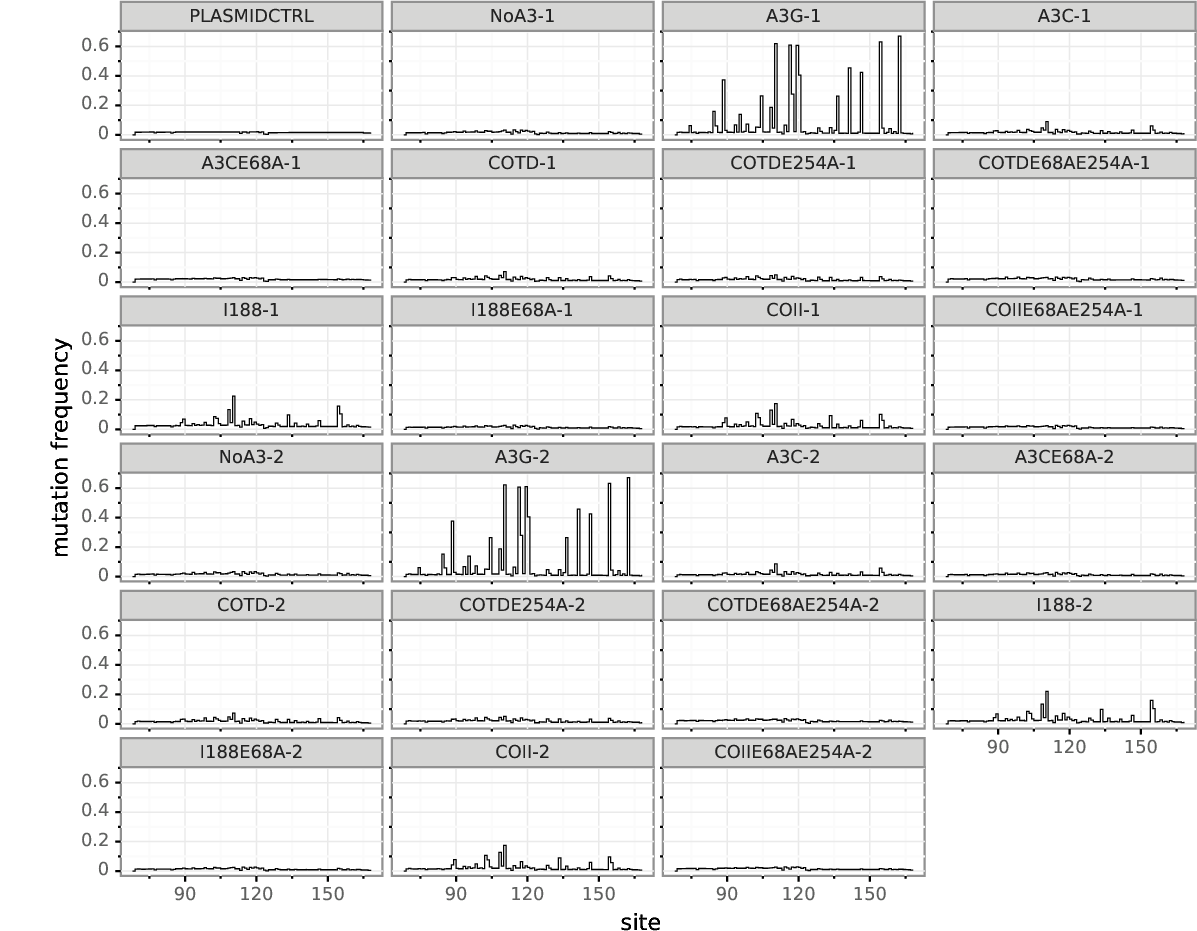

In [14]:
showPDF(countsplotprefix + '_mutfreq.pdf')

The `*_codonmuttypes.pdf` plot below shows the per-codon frequency of nonsynonymous, synonymous, and stop codon mutations across the entire gene. 

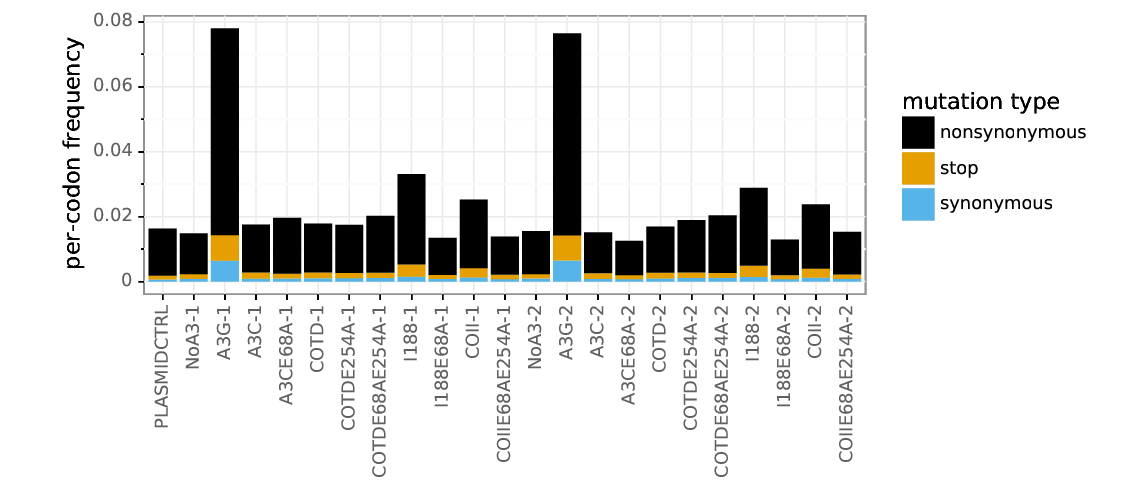

In [15]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=600)

The `*_codonntchanges.pdf` plot below shows same data as above but categorizes codon mutations by the number of nucleotides that are changed (e.g., ATG to AAG changes 1 nucleotide, ATG to AAC changes 2 nucleotides, and ATG to CAC changes 3 nucleotides).

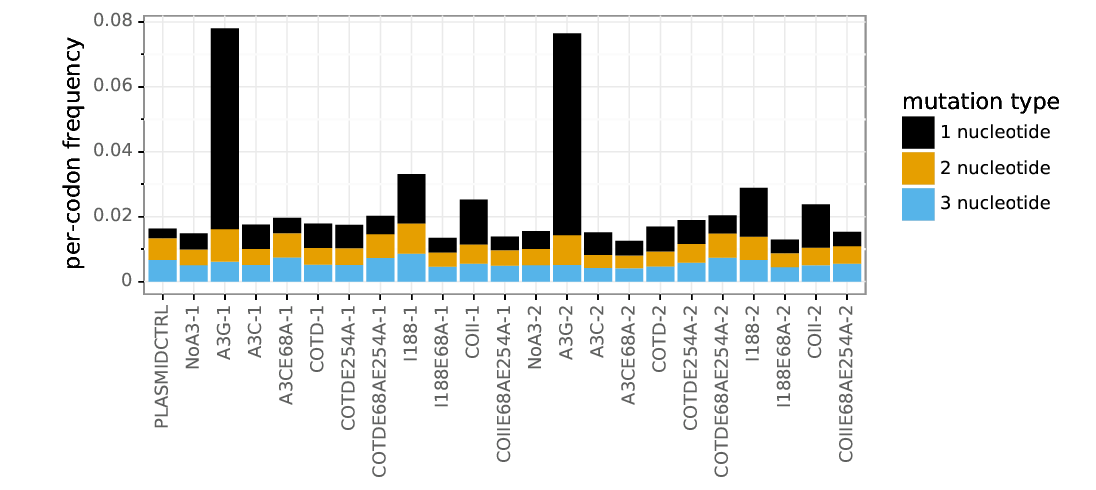

In [16]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=600)

The `*_singlentchanges.pdf` plot below shows the frequency of each type of nucleotide change among only codon mutations with one nucleotide change. This plot is mostly useful to check if there is a large bias in which mutations appear. In particular, if you are getting oxidative damage (which causes G to T mutations) during the library preparation process, you will see a large excess of C to A or G to T mutations (or both). There is not much oxidative damage in the samples plotted below, which mostly have a fairly even distribution of nucleotide changes.

We do see that transitions (G <-> A and C <-> T) are a bit more common than most of the other types of mutations (all of which are transversions). This is expected, since [PCR based sources of mutations are expected to preferentially introduce transitions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3720931/). 

This plot would also be important to examine any sign of APOBEC hypermutation (also G <-> A, with preferences for specific motifs) occuring in the HIV genome. One of the reasons we selected the SupT1.R5 cell line was because [there is very little of the APOBEC proteins expressed in  a subclone of SupT1 cells](https://www.ncbi.nlm.nih.gov/pubmed/20308164). In the viral samples, there does appear to be an increase in G to A and C to T mutations. However, we passaged WT virus in these cells and confirmed there were not signs of extensive APOBEC hypermutation in hotspot motifs via deep sequencing of env after passaging. Thus, we do not think there is extensive APOBEC hypermutation in our data, and this increase certain types of mutations in the viral samples is likely due to bias in the viral reverse transcription.

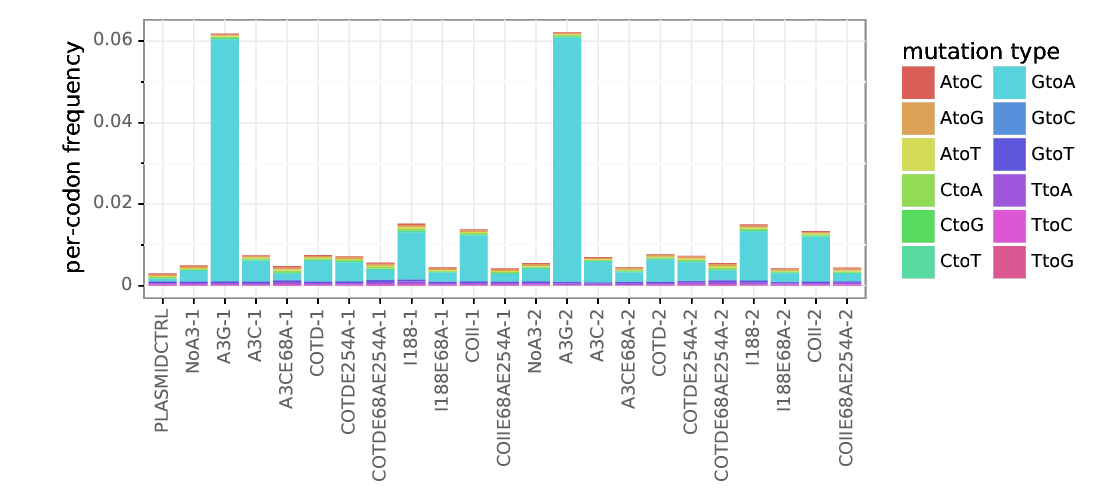

In [17]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=600)

# Analyze `bcinfo.csv.gz` output

The analysis immediately belwo uses the `.csv` output of the `bcinfo file` and makes a heatmap of mutation motifs. 

In [46]:
NTS = ('A', 'C', 'T', 'G', 'N')

def getSubstitutions_Nokay(mutant, wildtype):
    """Get space delimited string of substitutions

    Args:
        `wildtype` (str):
             The wildtype sequence
        `mutant` (str):
             The mutant sequence
    Returns:
        A space delimited string of substitutions present in the
        mutant sequence

    >>> getSubstitutions('AGT', 'TGT')
    'A1T'
    >>> getSubstitutions('AAGTAACGA', 'ATCTAACGA')
    'A2T G3C'
    """
    if mutant == 'None':
        return None
    elif len(wildtype) != len(mutant):
        print(wildtype)
        print(mutant)
        raise ValueError('wildtype and mutant must be same length')
    subs = []
    for site in range(len(wildtype)):
        wt = wildtype[site]
        mut = mutant[site]
        if mut == 'N':
            continue
        if wt not in NTS:
            raise ValueError (f"Invalid wt nucleotide {wt} at site {site+1}")
        if mut not in NTS:
            raise ValueError (f"Invalid mutant nucleotide {mut} at site {site+1}")
        if wt!=mut:
            pos = str(site + 1)
            subs.append(f"{wt}{pos}{mut}")
    subs = ' '.join(subs)

    return subs

In [47]:
def get_Ns(seq):
    if seq == 'None':
        return None
    else:
        return seq.count('N')

In [48]:
trimmedrefseq = "CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATAGGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCC"
bcinfo_dfs = {}
nts_retained = {}
nts_retained_no_Ns = {}
df_samplenames = []
for sample in samplenames:
    df_samplename = sample.replace('_', '-')
    df_samplenames.append(df_samplename)
for sample in df_samplenames:
    print(sample)
    subs_list = []
    bcinfo_file = f"{countsdir}/{sample}_bcinfo.csv.gz"
    bcinfo_df = pd.read_csv(bcinfo_file)
    bcinfo_df_retained = bcinfo_df[bcinfo_df['Retained'] == True].reset_index(drop=True)
    nts_retained[sample] = len(trimmedrefseq) * len(bcinfo_df_retained)
    bcinfo_df_retained['num_N'] = bcinfo_df_retained['Consensus'].apply(get_Ns)
    bcinfo_df_retained['subs'] = bcinfo_df_retained['Consensus'].apply(getSubstitutions_Nokay, args=(trimmedrefseq,))
    bcinfo_dfs[sample] = bcinfo_df_retained
    nts_retained_no_Ns[sample] = nts_retained[sample] - sum(bcinfo_df_retained['num_N'])
    display(bcinfo_dfs[sample].head())
print(nts_retained_no_Ns)
    

PLASMIDCTRL


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,CAAGATCGATTAAGCT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,1,
1,ACAGATCATGTGTATG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,1,
2,ATATCGACGAGTTCCC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
3,GATGTCTCTAGGGGAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
4,GGCGCGTCAGTCCAGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,


NoA3-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,CACAAACGTAAGCGGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,1,
1,TCCCTCCACGAGATAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,9,9,0,
2,ATCGGGGGCCTTGCTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,7,7,0,G61A G108A
3,AATGCTATACCAGAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,8,8,0,
4,CCAACGGTCCGCATTC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,6,6,0,


A3G-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,ACCGCCAGGGGGAATG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,1,G61A G118A G125A G142A G144A G145A G151A G154A...
1,ACTTCGCTATATCGTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,0,
2,GGAAGTGGAAGGCATC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,0,
3,ATCGGGAAACAATGTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,1,
4,AGCTGATTAGAAATCA,True,aligned at position 205,CCTCAGATCACTCTTTAGCAACGACCCCTCGTCACAATAAAAATAA...,4,4,0,G17A G42A G46A G47A G48A G49A G61A G73A G79A G...


A3C-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,CGAAACCCGAATCGGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
1,CGCGAATGCGGCATGC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
2,TGAGGCTGGCAAATTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
3,GTGGTGCGGAGAACCC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATNNAGATAG...,2,2,6,G103A G126A
4,ATTTGCCTCTTGGTGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,


A3CE68A-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,ATGACTACGTTTAGTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
1,AGTTCCTTCACCGGTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
2,ATGGAGTTGATTGCAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,1,
3,AAGGGCAAGATTGTTT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
4,CACTCAATTTTGTTAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,


COTD-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,CGAAATCGGCCTTCAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
1,GCTAGCAATAAGACAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,0,G88A G178A G260A
2,CAAACAAGAAGGTCGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,0,
3,ATAACCGGGCATGGGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,2,
4,AGTGAAGCTGTACGTC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,1,


COTDE254A-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,CGGTTCAAGCCGATGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,0,
1,ACGCTTCGGTCATTGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
2,CAGCGCAGCGAGCATA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
3,GAAAAACTGACGGATA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,0,
4,CCTGTGTAGTACGGTG,True,aligned at position 205,CCTCAGATCACTCTTTGGTAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,C19T


COTDE68AE254A-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,AAGGAGTAAACAGAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,0,
1,TCACTGTCGAGGTCGC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,5,5,0,G138T
2,AGAAGTCTCAGACCTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,0,
3,GCAGAGTGGGAGTCTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,0,
4,TAATAAAAAGGGATGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,0,


I188-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,AAGCACAGTGGCGCAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,G119A G125A G257A G260A
1,CATATCTGTACGGAGC,True,aligned at position 205,CCTCTGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,A5T
2,TGGTTGAAGTGCCCTC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
3,AGAGTAAAGGGTTCCA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,1,
4,TCAACCTGTGCCGGTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,G256A


I188E68A-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,GCTAGGAGACCTAAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
1,GTGGAGAAAAGTTGGC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
2,GGGCTAGAATCCTTAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,0,
3,TAGTTGTGAATGATGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,1,
4,GAAAACGAGGGTACGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,


COII-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,GAGCGGTCGATCAGAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,6,6,0,
1,CACAGAAAGCAAAAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,7,7,0,
2,CTGATGAGCGTATTAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,0,
3,GCACCATGGGTATAGC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,1,G100A G178A G193A G256A
4,ATCGTGGTGCGCATTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,5,5,0,G61A G100A G103A G108A G125A G126A G155A G193A...


COIIE68AE254A-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,CATTTATTTATCGTGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,0,
1,GGGTAGTAGATGACGC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,0,
2,AGCACGTGTAAGGTAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
3,GAACCGCTCCTGGACC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,5,5,0,
4,CGGGCGGGAGTGGGGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,


NoA3-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,GCACCCGGAACAGGCT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
1,TAAACAAATCCAGCAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
2,AGTCCAGGGTATTGCC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
3,AAATACGCAAGAACCT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,3,G61A G73A G88A G138A G151A G233A G260A G270A G...
4,CACTTAGCGGCCTAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,0,


A3G-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,GGCTCTACCGCCTGAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,G60A G119A G125A G142A G144A G232A G256A G280A
1,CTAACAAGCGTTAGAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAA...,2,2,2,G46A G49A G60A G125A G142A G144A G145A G151A G...
2,TACGTGACCACTAAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,G100A G144A G151A
3,ACCAGCGGCGTGCTTT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,1,
4,AGCCAATTGTGTGATT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAA...,4,4,0,G46A G73A G125A G126A G142A G143A G144A G145A ...


A3C-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,AAAGAGATCGCGCAGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,9,
1,GCCAATCGAGCAGAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
2,GCTGTGGCGAAATCAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,1,
3,TAGGTAAGCAGTGTAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,6,
4,AGGGTCACATATCAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,0,


A3CE68A-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,TGGAACGCTCACGACG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,0,
1,GGTGTAGCGGATTGGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCNCTCGTCACAATAAAGATAG...,3,3,1,
2,AGTAGTAGGCATCGAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
3,AGGGAACAGATCCATG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,0,G100A
4,GCCCTTAGGCGGAGAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,


COTD-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,GCTGGAACCATTCACA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
1,ATACACACTCTCATAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,0,G119A
2,TGCAAAATTGCGTATC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
3,GAAACCAGTGGCGTTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
4,AAAGCACGGGTGCGAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,


COTDE254A-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,GCGTATGGGCGCTGTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,7,7,0,
1,ATCGATTTCGCCTGGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,8,8,0,G218A
2,CAAATGACTTGAAAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,8,8,0,G108T
3,AAGTTCGGCTACCCTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,13,13,0,
4,TGAAAACGGTGCGGTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,5,5,0,


COTDE68AE254A-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,CAGGGTGGGATATTTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,0,
1,GACGTGCTCGTACCAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,1,
2,GAGCCTCGGTTCGGTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,1,A153T
3,AAAGCTAGTGACGTTC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
4,ACTGTGGCGAATATTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,0,G122A


I188-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,ATATAGCCCAGTTGGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,2,A136T T137G G138A A139T T140A A141G G146A A148...
1,AGAAAGACCGACGCGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,0,
2,TGGCAAATGTAGGATA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,0,
3,GTAAGTAAATATACAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,0,
4,AGGTCCTGGTTCAAAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,0,G60A G119A G125A G166A G193A G257A


I188E68A-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,GACCAATTATAGGCTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,0,
1,TGGGGCACCGTTCATA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
2,AAGAAGCACTCTTTGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,6,6,0,
3,GCCAAGGTAAGTACTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,2,A136T T137G G138A A139T T140A A141G G146A A148...
4,AGCAACACAGTAACGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,


COII-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,ACCATATACTTGCTGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
1,GCAACGGGTCAAGGCA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,7,7,0,G202A G256A
2,TGGTATCCGGTGGCCG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,0,
3,AGTGTACCTAAGGCTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,5,5,0,
4,CTAGCGGCATGCGCCC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,G126A G138A G223A


COIIE68AE254A-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs
0,CTAAGTCCTATACGTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,6,6,0,
1,GCAAGGAAAAGGATCG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
2,AGCGCATGGTAACTCA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,0,
3,TACTTCGTGTCAGAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGATAG...,2,2,0,A34G
4,ACTTTAACAGAACGAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,0,


{'PLASMIDCTRL': 27902283, 'NoA3-1': 52996806, 'A3G-1': 175669265, 'A3C-1': 7105720, 'A3CE68A-1': 59964892, 'COTD-1': 157810247, 'COTDE254A-1': 51772117, 'COTDE68AE254A-1': 160287143, 'I188-1': 32534649, 'I188E68A-1': 67268537, 'COII-1': 56682717, 'COIIE68AE254A-1': 67458816, 'NoA3-2': 36038472, 'A3G-2': 52284541, 'A3C-2': 75341059, 'A3CE68A-2': 33349677, 'COTD-2': 121146536, 'COTDE254A-2': 57941122, 'COTDE68AE254A-2': 67511300, 'I188-2': 108715253, 'I188E68A-2': 161068297, 'COII-2': 128939252, 'COIIE68AE254A-2': 157262586}


In [49]:
def subs_to_motifs(subs_list, gene):
    """Return substitution as tuple (5'nt, sub, 3'nt)."""
    motifs = []
    for sub in subs_list:
        site = int(sub[1:-1])
        change = f"{sub[0]}{sub[-1]}"
        if site == 1:
            threeprime_nt = gene[site]
            motif = (None, change, threeprime_nt)
        elif site == len(gene):
            fiveprime_nt = gene[site-2]
            motif = (fiveprime_nt, change, None)
        else:
            fiveprime_nt = gene[site-2]
            threeprime_nt = gene[site]
            motif = (fiveprime_nt, change, threeprime_nt)
        motifs.append(motif)
    return(motifs)

In [50]:
mutinfo_dfs = {}
for sample in df_samplenames:
    print(sample)
    sample_mut_motifs = []
    sample_num_muts = []
    bcinfo_df = bcinfo_dfs[sample]
    sample_reads = len(bcinfo_df)
    bcs_with_subs = bcinfo_df[bcinfo_df['subs'] != ''].reset_index(drop=True)
    sample_sub_reads = len(bcs_with_subs)
    # 'N's not counted as subs
    print(f"{sample_sub_reads} out of {sample_reads} barcodes ({round(sample_sub_reads/sample_reads*100, 2)}%) for {sample} have substitutions")
    for i in range(len(bcs_with_subs)):
        subs_list = bcs_with_subs.iloc[i]['subs'].split(' ')
        num_muts = len(subs_list)
        mut_motifs = subs_to_motifs(subs_list, trimmedrefseq)
        sample_mut_motifs.append([mut_motifs])
        sample_num_muts.append(num_muts)
    sample_mutinfo_df = bcs_with_subs.join(pd.DataFrame(sample_mut_motifs, columns=['sub_tups']))
    sample_mutinfo_df['n_subs'] = sample_num_muts
    mutinfo_dfs[sample] = sample_mutinfo_df
    display(mutinfo_dfs[sample].sort_values('n_subs', ascending=False).head(10))

PLASMIDCTRL
4483 out of 93226 barcodes (4.81%) for PLASMIDCTRL have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
1262,TTCAAATAAATTGCAG,True,aligned at position 205,TATTGGTATCAGGGTTAATCGTGCCAAGAAAAGCGGCATGGTCAAT...,2,2,1,C1T C2A C4T A5G A7T T8A C9T A10C C11A T12G C13...,"[(None, CT, C), (C, CA, T), (T, CT, A), (C, AG...",240
1051,GCCGCATGAAATAACC,True,aligned at position 205,GGTCAGATTGGTCGTCTTATTACCATTTCAACTACTCCGGTTATCG...,2,2,2,C1G C2G C9T A10G C11G T14G T16C G17T G18T C19A...,"[(None, CG, C), (C, CG, T), (T, CT, A), (C, AG...",240
1599,AATTCAGCGTCCGATG,True,aligned at position 205,GAATGTTGACGGGATGAACATAATAAGCAATGACGGCAGCAATAAA...,2,2,7,C1G C2A T3A C4T A5G G6T A7T T8G C9A A10C C11G ...,"[(None, CG, C), (C, CA, T), (C, TA, C), (T, CT...",238
2385,GATGCTGTCGACGCCA,True,aligned at position 205,GAGTCAAGTTACTGAACAATCCGTACGTTTCCAGACCGCTTTGGCC...,2,2,3,C1G C2A T3G C4T A5C G6A T8G C9T A10T C11A T12C...,"[(None, CG, C), (C, CA, T), (C, TG, C), (T, CT...",237
3411,TGAATGCACAATCTGC,True,aligned at position 205,TAACCGTCAAACTATCAAAATATAACGTTGACGATGTAGCTTTAGG...,2,2,2,C1T C2A T3A A5C A7T T8C C9A C11A T12C C13T T14...,"[(None, CT, C), (C, CA, T), (C, TA, C), (C, AC...",237
809,TGCTTGGAGTGGCAAG,True,aligned at position 205,CAACGCGAGCAGTAGACTCCTTCTGTTGATAAGCAAGCATCTCATT...,2,2,5,C2A T3A A5G G6C A7G T8A C9G A10C C11A T12G C13...,"[(C, CA, T), (C, TA, C), (C, AG, G), (A, GC, A...",236
4213,GCTGAATATGGTGATA,True,aligned at position 205,GGANGCCTCCAGCAATCTTGAACACTCATCCTTAATACCTTTCTTT...,2,2,4,C1G C2G T3A A5G G6C A7C A10C C11A T12G T14A T1...,"[(None, CG, C), (C, CG, T), (C, TA, C), (C, AG...",236
2037,CAGCACGCAAAGCCGC,True,aligned at position 205,AGCAGCAAGATAATCACGAGTATCCTTTCCTTTANCAGCGGCAGAC...,2,2,3,C1A C2G T3C C4A A5G G6C T8A C9G C11T T12A C13A...,"[(None, CA, C), (C, CG, T), (C, TC, C), (T, CA...",236
362,GTTTGGTCAGGCTAAC,True,aligned at position 205,CCCAGAGATTAGAGCGCATGACAAGTAAAGGACGGTTGTCAGCGTC...,2,2,3,T3C C4A A5G G6A A7G T8A C9T A10T C11A T12G C13...,"[(C, TC, C), (T, CA, A), (C, AG, G), (A, GA, A...",235
406,TGATAAGCACGTTGCA,True,aligned at position 205,GNTCTTTCGTNTTCTGGCGTGAAGTCGCCGACTGAATGCCAGCAAT...,2,2,3,C1G A5T G6T A7T T8C C9G A10T C13T T14C T16G G1...,"[(None, CG, C), (C, AT, G), (A, GT, A), (G, AT...",235


NoA3-1
28259 out of 176750 barcodes (15.99%) for NoA3-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
24193,AAGAAACGTCCGTTGC,True,aligned at position 205,GAACACGACCAGAAAACTGGCCTAACGACGTTTGGTCAGTTCCATC...,2,2,4,C1G C2A T3A G6C A7G T8A A10C C11A T12G C13A T1...,"[(None, CG, C), (C, CA, T), (C, TA, C), (A, GC...",243
7532,TCCAAAGGGGTTTTCT,True,aligned at position 205,TAGTCGGAACCGAAGAAGACTCAAAGCGAACCAAACAGGCAAAAAA...,2,2,3,C1T C2A T3G C4T A5C A7G T8A C9A A10C T12G C13A...,"[(None, CT, C), (C, CA, T), (C, TG, C), (T, CT...",240
18447,TTCGCCATGGTCAGTA,True,aligned at position 205,CGCGTTGGATGAGGAGAAGTGGCTTAATATGCTTGGCACGTTCGTC...,2,2,3,C2G T3C C4G A5T G6T A7G T8G C9A A10T C11G T12A...,"[(C, CG, T), (C, TC, C), (T, CG, A), (C, AT, G...",238
25693,AAATCGCGACCAAAAT,True,aligned at position 205,TGAATGCAATGCGACAGGCNCATGCTGATGGTTGGTTTATCGTTTT...,2,2,4,C1T C2G T3A C4A A5T A7C T8A C9A A10T C11G T12C...,"[(None, CT, C), (C, CG, T), (C, TA, C), (T, CA...",237
24701,AATTATGGGCCTTCGT,True,aligned at position 205,TAAACTCCTAAGCAGAAAACCTACCGCGCTTCGCTTGGTCAACCCC...,2,2,2,C1T C2A T3A C4A A5C G6T A7C T8C C9T C11A T12G ...,"[(None, CT, C), (C, CA, T), (C, TA, C), (T, CA...",236
23320,TTTACCGCCCTTCAAG,True,aligned at position 205,TGANTCAGGTTATTAAAGNGATTATTTGTCTCCAGCCACTTAAGTG...,2,2,10,C1T C2G T3A A5T G6C T8G C9G A10T C11T T12A C13...,"[(None, CT, C), (C, CG, T), (C, TA, C), (C, AT...",234
11857,AGACGCAATGGCACTT,True,aligned at position 205,TAAGCAAGCATCTCATTTTGTGCATATACCTGGTCTTTCGTATTCT...,2,2,0,C1T C2A T3A C4G A5C G6A T8G C11T T12C C13T T14...,"[(None, CT, C), (C, CA, T), (C, TA, C), (T, CG...",234
14990,CGGGTACGGATTTGTC,True,aligned at position 205,AAAATACGTGGCCTTATGGTTNCAGTATGCCCATCGCAGTTCGCTA...,2,2,6,C1A C2A T3A C4A A5T G6A A7C T8G C9T A10G C11G ...,"[(None, CA, C), (C, CA, T), (C, TA, C), (T, CA...",233
28133,ATTCGCGAGGAAGTGT,True,aligned at position 205,GTATTAAGGATGAGTGTTCAAGATTGCTGGAGGCCTCCACTATGAA...,2,2,4,C1G C2T T3A C4T A5T G6A T8G C9G C11T T12G C13A...,"[(None, CG, C), (C, CT, T), (C, TA, C), (T, CT...",233
27982,GAGCGTCCAAGCCAAG,True,aligned at position 205,TTACCTTGCGTGTACGCGCAGGAAACACTGACGTTCTTACTGACGC...,2,2,4,C1T C2T T3A A5C G6T A7T T8G A10G C11T T12G C13...,"[(None, CT, C), (C, CT, T), (C, TA, C), (C, AC...",231


A3G-1
522481 out of 586737 barcodes (89.05%) for A3G-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
62024,ATTTTGATGAAACCAA,True,aligned at position 205,TGGTTTTCTTCATTGCATTCAGATGGATACATCTGTCAACGCCGCT...,2,2,5,C1T C2G T3G C4T A5T G6T A7T T8C C9T A10T T12A ...,"[(None, CT, C), (C, CG, T), (C, TG, C), (T, CT...",249
274823,GGCCCCTTGCGGCATG,True,aligned at position 205,TCAAACTGGCGCCGAGCGTATGCCGCATGACCTTTCCCATCTTGGC...,2,2,1,C1T T3A C4A G6C A7T T8G C9G A10C C11G T12C T14...,"[(None, CT, C), (C, TA, C), (T, CA, A), (A, GC...",244
358031,GGCCCCTTTGGTCAAT,True,aligned at position 205,TCAAACTGGCGCCGAGCGTATGCCGCATGACCTTTCCCATCTTGGC...,2,2,4,C1T T3A C4A G6C A7T T8G C9G A10C C11G T12C T14...,"[(None, CT, C), (C, TA, C), (T, CA, A), (A, GC...",243
194014,CTTTTTGGGTGGCATT,True,aligned at position 205,TTAAGAGGGCGTTCAGCAGCCAGCTTGCGGCAAAACTGCGTAACCG...,2,2,2,C1T C2T T3A C4A A5G G6A A7G T8G C9G A10C C11G ...,"[(None, CT, C), (C, CT, T), (C, TA, C), (T, CA...",242
362391,GCATTCAGAGAAGCAA,True,aligned at position 205,TCAGGTTGTTTCTGTTGGTGCTGATATTGCTTTTGATGCCGACCCT...,2,2,3,C1T T3A C4G A5G G6T A7T T8G C9T A10T C11T T12C...,"[(None, CT, C), (C, TA, C), (T, CG, A), (C, AG...",242
78709,TGCGTTCTATGCCCAT,True,aligned at position 205,GCGTCGTAACCCAGCTTGGTAAGTTGGNTTAAGCACTCCGTGGACN...,2,2,10,C1G T3G C4T A5C A7T T8A C9A A10C T12C C13A T14...,"[(None, CG, C), (C, TG, C), (T, CT, A), (C, AC...",240
269428,TTTATTGTGAGCAGGG,True,aligned at position 205,TCATTTCGTTATGTACCCAGTAGTCATTCAGGAGCAGGTTGTTCAG...,2,2,8,C1T T3A C4T A5T G6T A7C T8G C9T A10T C11A C13G...,"[(None, CT, C), (C, TA, C), (T, CT, A), (C, AT...",240
471992,GAAACCAAAAGCTACA,True,aligned at position 205,TAGACCAAACCATGAAACCAACATAAACATTATTGCCCGGCGTACG...,2,2,1,C1T C2A T3G C4A A5C G6C T8A C9A A10C T12A C13T...,"[(None, CT, C), (C, CA, T), (C, TG, C), (T, CA...",240
70223,ATGATTTCTACCTTTA,True,aligned at position 205,GATTGCTACTGACCGCTCTCGTGCTCGTCGCTGCGTTGAGGCTTGC...,2,2,0,C1G C2A C4T A5G G6C A7T T8A A10T C11G T12A T14...,"[(None, CG, C), (C, CA, T), (T, CT, A), (C, AG...",239
33694,AAAAAGCCCCGGCGTC,True,aligned at position 205,GCTTGCTACCGATAACAATACTGTNGGCATGGGTGATGCTGGTATT...,2,2,5,C1G C4T A5G G6C A7T T8A A10C C11G T12A C13T T1...,"[(None, CG, C), (T, CT, A), (C, AG, G), (A, GC...",238


A3C-1
7937 out of 23733 barcodes (33.44%) for A3C-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
681,TATTCAGCTGCGATGG,True,aligned at position 205,CATGCTGATGGTTGGTTTATCGTTTTTGACACTCTCACGTTGGCTG...,2,2,3,C2A C4G A5C G6T A7G T8A C9T A10G C11G C13T T14...,"[(C, CA, T), (T, CG, A), (C, AC, G), (A, GT, A...",233
4530,TTGACCATACGGTTGT,True,aligned at position 205,TGATACCAATNAAATCCCTAAGCATTTGTTTCAGGGTTATTTGAAT...,2,2,4,C1T C2G T3A C4T G6C A7C T8A C9A A10T T12A C13A...,"[(None, CT, C), (C, CG, T), (C, TA, C), (T, CT...",231
237,AATACTGTTAAGCTCT,True,aligned at position 205,CTGCCATTCAAGGCTCTANTGTTCCTAACCCTGATGAGGCCGTCCC...,2,2,4,C2T T3G A5C G6A A7T C11A T12G C13G T14C T16C G...,"[(C, CT, T), (C, TG, C), (C, AC, G), (A, GA, A...",230
3286,TCCCCAATCCTTTCTT,True,aligned at position 205,ACCGCATCAAGCTCTTGGAAGAGATTCTGTCTTTTCGTATGCAGGG...,2,2,3,C1A T3C C4G A5C G6A A7T T8C C9A C11G T12C C13T...,"[(None, CA, C), (C, TC, C), (T, CG, A), (C, AC...",230
2212,CAGGAAGGGATACCCC,True,aligned at position 205,TCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCA...,2,2,1,C1T T3A A5T G6C A7T C9T A10G C11G T12C C13A T1...,"[(None, CT, C), (C, TA, C), (C, AT, G), (A, GC...",230
2573,CGGCAGATAACGCTAA,True,aligned at position 205,ACCTGACTATTCCACTGCAACAACTGAACGGACTGGAAACACTGGT...,2,2,2,C1A T3C C4T A5G G6A A7C C9A A10T C11T T12C T14...,"[(None, CA, C), (C, TC, C), (T, CT, A), (C, AG...",227
6319,CATCATCTTATATTGA,True,aligned at position 205,GGTACGGTCAGGCATNCACGGCGCTTTAAAATAGTTGTTATAGATA...,2,2,2,C1G C2G C4A A5C A7G C11G T12G T14A G17C G18A A...,"[(None, CG, C), (C, CG, T), (T, CA, A), (C, AC...",227
160,AGCTTGCAGTCGTAAC,True,aligned at position 205,TGCCCATCGCAGTTCGCTACACGCAGGACGCTTTTTCACGTTCTGG...,2,2,6,C1T C2G T3C A5C G6A A7T T8C C9G A10C C11A T12G...,"[(None, CT, C), (C, CG, T), (C, TC, C), (C, AC...",227
2865,GAAGAAGATAAAAATT,True,aligned at position 205,ATTTAGGGTCGGCATCAAAAGCAATATCAGCACCAACAGAAACAAC...,2,2,0,C1A C2T C4T A7G T8G C9T A10C C11G T12G T14A T1...,"[(None, CA, C), (C, CT, T), (T, CT, A), (G, AG...",225
4825,GACCAGAAACTATTTT,True,aligned at position 205,TCCATCAACATCATAGCCAGATGCCCAGAGATTAGAGCGCATGACA...,2,2,4,C1T T3C C4A A5T G6C T8A C11T T12C C13A T15A T1...,"[(None, CT, C), (C, TC, C), (T, CA, A), (C, AT...",225


A3CE68A-1
26934 out of 200292 barcodes (13.45%) for A3CE68A-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
6579,TGGTATCACTAATATT,True,aligned at position 205,ATGGTCAATATAACCAGTAGTGTTAACAGTCGGGAGAGGAGTGGCA...,3,3,3,C1A C2T T3G C4G A5T G6C T8A C9T C11T T12A C13A...,"[(None, CA, C), (C, CT, T), (C, TG, C), (T, CG...",244
21387,GTCTAAGATATGGCGA,True,aligned at position 205,TATCGTTATGCGCCTTCGTATGTTTCTCCTGCTTATCACCTTCTTG...,2,2,3,C1T C2A A5G G6T A7T T8A C9T A10G T12G T14C G17...,"[(None, CT, C), (C, CA, T), (C, AG, G), (A, GT...",242
8827,TTCTCCTGTATGGCGA,True,aligned at position 205,TTCATTCNGNAACCGCCTTCTGGTGATTTGCAAGNACGCGTACTTN...,2,2,7,C1T C2T T3C C4A A5T G6T A7C C9G C11A T12A T14C...,"[(None, CT, C), (C, CT, T), (C, TC, C), (T, CA...",240
1580,ACCCTCGCTGCAATTA,True,aligned at position 205,TGCCGTCATTGCTTATTATGTTCATCCCGTCAACATTCAAACGGCC...,2,2,6,C1T C2G T3C A5G G6T A7C T8A C9T A10T C11G T12C...,"[(None, CT, C), (C, CG, T), (C, TC, C), (C, AG...",240
3322,GAATGTTTAGCTTAAT,True,aligned at position 205,ACTGGCCTAACGACGTTTGGTCAGTTCCATCAACATCATAGCCAGN...,2,2,6,C1A C4G A5G G6C A7C C9A T12G C13A T14C T15G G1...,"[(None, CA, C), (T, CG, A), (C, AG, G), (A, GC...",239
19338,TTCAAATACTAATATT,True,aligned at position 205,TATTGGTATCAGGGTTAATCGTGCCNAGAAAAGCGGCATGGTCAAT...,2,2,9,C1T C2A C4T A5G A7T T8A C9T A10C C11A T12G C13...,"[(None, CT, C), (C, CA, T), (T, CT, A), (C, AG...",239
2087,AGCTCATTTTCTTCTG,True,aligned at position 205,CGAAGATGATTTCGATTTTCTGACGAGTAACAAAGTTTGGATTGCT...,3,3,2,C2G T3A C4A A5G G6A A7T T8G C9A A10T C11T T14G...,"[(C, CG, T), (C, TA, C), (T, CA, A), (C, AG, G...",238
1701,AAAATGAGACATTAGA,True,aligned at position 205,GTCGGCGACTTCACGCCAGAATACGAAAGACCAGGTATATGCACAA...,2,2,3,C1G C2T T3C C4G A5G G6C A7G T8A A10T C11T T12C...,"[(None, CG, C), (C, CT, T), (C, TC, C), (T, CG...",238
1474,GACGCAGAAATGGAGA,True,aligned at position 205,CAGAAGGAGTGATGTAATGTCTAAAGGTAAAAAACGTTCTGGCGCT...,2,2,1,C2A T3G C4A A7G T8A C9G A10T C11G T12A C13T T1...,"[(C, CA, T), (C, TG, C), (T, CA, A), (G, AG, T...",238
15243,TACTGCGAATTAAATT,True,aligned at position 205,AAAGGTGCTTTGACTTATACCGATATTGCTGGCGACCCTGTTTTGT...,2,2,4,C1A C2A T3A C4G A5G G6T A7G T8C C9T A10T C11T ...,"[(None, CA, C), (C, CA, T), (C, TA, C), (T, CG...",238


COTD-1
169712 out of 527096 barcodes (32.2%) for COTD-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
102960,ACTCCTTCTGGCACTT,True,aligned at position 205,TGCATATACCTGGTCTTTCGTATTCTGGCGTGAAGTCGCCGACTGA...,2,2,2,C1T C2G T3C C4A A5T G6A A7T T8A A10C C11T T12G...,"[(None, CT, C), (C, CG, T), (C, TC, C), (T, CA...",245
24573,TTAATGGCATAAGACG,True,aligned at position 205,ATTGTTCGCGTTTACCTTGCGTGTACGCGCAGGAAACACTGACGTT...,2,2,4,C1A C2T C4G A5T G6T A7C T8G A10G C11T C13T T14...,"[(None, CA, C), (C, CT, T), (T, CG, A), (C, AT...",244
14857,CCTACAGGATTGTGAG,True,aligned at position 205,GGGTACGCAATCGCCGCCAGTTAAATAGCTTGCAAAATACGTGGCC...,2,2,2,C1G C2G T3G C4T G6C A7G T8C C9A C11T T12C C13G...,"[(None, CG, C), (C, CG, T), (C, TG, C), (T, CT...",244
129079,TGAGTATGGACAGCTT,True,aligned at position 205,CATGCGGTGCACTTTATGCGGACACTTCCTACAGGTAGCGTTGACC...,2,2,10,C2A C4G A5C A7G C9G A10C C11A T12C C13T T16A G...,"[(C, CA, T), (T, CG, A), (C, AC, G), (G, AG, T...",243
2381,AATCCGTAAAGGTAAA,True,aligned at position 205,TAAGCTCATTCAGGCTTCTGCCGTTTTGGATTTAACCGAAGATGAT...,2,2,3,C1T C2A T3A C4G A5C G6T A7C T8A C9T A10T T12A ...,"[(None, CT, C), (C, CA, T), (C, TA, C), (T, CG...",243
11113,GATGCTGTAAGGTAAA,True,aligned at position 205,GAGTCAAGTTACTGAACAATCCGTACGTTTCCAGACCGCTTTGGCC...,2,2,3,C1G C2A T3G C4T A5C G6A T8G C9T A10T C11A T12C...,"[(None, CG, C), (C, CA, T), (C, TG, C), (T, CT...",242
136794,GACTACCCCCTACAGT,True,aligned at position 205,TTGGATGGTCGCCATGATGGTGGTTATTATACCGTCAAGGACTGTG...,2,2,2,C1T C2T T3G C4G G6T A7G T8G C9T A10C C11G T12C...,"[(None, CT, C), (C, CT, T), (C, TG, C), (T, CG...",241
97574,TTAATATGAAAGCGAG,True,aligned at position 205,TAGATATGAGTCACATTTTGTTCATGGTAGAGATTCTCTTGTTGAC...,2,2,5,C1T C2A T3G C4A A5T G6A A7T T8G C9A A10G C11T ...,"[(None, CT, C), (C, CA, T), (C, TG, C), (T, CA...",241
50775,TAGCTCCTTATCAGTA,True,aligned at position 205,TGACTTTTTGTTAACGTATTTAGCCACATAGAAACCAACAGCCATN...,2,2,3,C1T C2G T3A A5T G6T A7T C9T A10G C11T C13A T14...,"[(None, CT, C), (C, CG, T), (C, TA, C), (C, AT...",240
6046,GCTATCAGGACAGCTT,True,aligned at position 205,AGCTAATGGCCGTCTTCATTTCCATGCGGTGCACTTTATGCGGACA...,2,2,2,C1A C2G T3C C4T G6A A7T T8G C9G A10C T12G C13T...,"[(None, CA, C), (C, CG, T), (C, TC, C), (T, CT...",240


COTDE254A-1
54011 out of 172895 barcodes (31.24%) for COTDE254A-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
26721,GCAAACAAGTGTTCAC,True,aligned at position 205,CAGAAAGCAGTGCGGCTCAAACTTGGATGCACATGCGCCTGCCTGG...,2,2,6,C2A T3G C4A G6A A7G T8C C9A A10G C11T T12G T14...,"[(C, CA, T), (C, TG, C), (T, CA, A), (A, GA, A...",244
4856,TTCATGGTGTACCTTC,True,aligned at position 205,GCCGCGGATTGGTTTCGCTGAATCAGGTTATTAANGAGATTATTTG...,2,2,4,C1G T3C C4G A5C A7G T8A C9T A10T C11G T12G C13...,"[(None, CG, C), (C, TC, C), (T, CG, A), (C, AC...",239
27222,TCTCATTGTGCAAAGT,True,aligned at position 205,AGCTTGCCTAAAGCACAGCTTCTAAACAGATGAGCCCTCCCCACGT...,2,2,3,C1A C2G T3C C4T A5T A7C T8C C9T C11A T12A C13G...,"[(None, CA, C), (C, CG, T), (C, TC, C), (T, CT...",238
42332,CATAAAAACTGGCGCT,True,aligned at position 205,AGCAAGGCCACGACGCAATGGAGAAAGACGGAGAGCGCCAACGGCG...,2,2,3,C1A C2G T3C C4A A7G T8C T12G C13A T14C T15G T1...,"[(None, CA, C), (C, CG, T), (C, TC, C), (T, CA...",236
10221,TCATGGAACTTGCTGC,True,aligned at position 205,GCCAATCATNTTTATCGAAGCGCGCATAAATTTGAGCAGATTTGTC...,2,2,9,C1G T3C C4A G6T A7C T8A C9T C11T C13T T14A T16...,"[(None, CG, C), (C, TC, C), (T, CA, A), (A, GT...",235
28618,GATTTCGAACCTTTAG,True,aligned at position 205,TTGCTACTGACCGCTCTCGTGCTCGTCGCTGCGTTGAGGCTTGCGT...,2,2,10,C1T C2T T3G A5T G6A A7C C9G T12C C13G T14C T16...,"[(None, CT, C), (C, CT, T), (C, TG, C), (C, AT...",234
21428,TCAAAGAAATTCAGAA,True,aligned at position 205,TGACTTAGTTCATCAGCAAACGCAGAATCAGNGGTATGGCTCTTCT...,2,2,5,C1T C2G T3A A5T G6T T8G C9T A10T T12A C13T T14...,"[(None, CT, C), (C, CG, T), (C, TA, C), (C, AT...",233
24905,TGGGAGGCTTATCCAC,True,aligned at position 205,AGAAGTTAGACTATATAATTATTAATTTATTAGTTTGTAGCCTGTC...,4,4,1,C1A C2G T3A C4A A5G G6T A7T T8A C9G C13A T15A ...,"[(None, CA, C), (C, CG, T), (C, TA, C), (T, CA...",232
51623,ATTTGAGAGACGACAT,True,aligned at position 205,CTGGACAATCAGAAAGAGATTGCCGAGATGCAAAATGAGACTCAAA...,2,2,4,C2T T3G C4G G6C T8A C9T A10C C11A T12G C13A T1...,"[(C, CT, T), (C, TG, C), (T, CG, A), (A, GC, A...",232
20459,ATGAGGCCGCCGACTG,True,aligned at position 205,GGCTAAAGCNGGTAAAGGACTTCTTGAAGGTACGTTGCAGGCTGGC...,2,2,10,C1G C2G T3C C4T G6A T8G C11G T12G C13T T14A T1...,"[(None, CG, C), (C, CG, T), (C, TC, C), (T, CT...",232


COTDE68AE254A-1
76369 out of 534952 barcodes (14.28%) for COTDE68AE254A-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
7019,CTAAGCAGTCTAAGAA,True,aligned at position 205,ACCCCTCAGCGGCAAAAATTAAAATTTTTACCGCTTCGGCGTTATA...,2,2,3,C1A T3C A5C G6T A7C T8A C9G A10C C11G T12G T14...,"[(None, CA, C), (C, TC, C), (C, AC, G), (A, GT...",246
37536,TAGCTCCTTGCCGAGG,True,aligned at position 205,TGACTTTTTGTTAACGTATTTAGCCACATAGAAACCAACAGCCATA...,2,2,5,C1T C2G T3A A5T G6T A7T C9T A10G C11T C13A T14...,"[(None, CT, C), (C, CG, T), (C, TA, C), (C, AT...",246
64525,ACGTGCACAGCACGAG,True,aligned at position 205,GGAGTTGGCGGGGAGGGAATGGCTGAAATTAAACATGGTGATTATC...,2,2,6,C1G C2G T3A C4G A5T G6T A7G T8G A10G C11G T12G...,"[(None, CG, C), (C, CG, T), (C, TA, C), (T, CG...",246
72282,TATTGGTCGGTCCATA,True,aligned at position 205,AAGGCTAATGATTCACACGCCGACTGCTATCAGTATTTTTGTGTGC...,2,2,4,C1A C2A T3G C4G A5C G6T T8A C9T A10G C11A C13T...,"[(None, CA, C), (C, CA, T), (C, TG, C), (T, CG...",245
46760,GTTCCATCTGAATATC,True,aligned at position 205,TAGAGCGCATGACAAGTAAAGGACGGTTGTCAGCGTCATAAGAGGT...,3,3,2,C1T C2A T3G C4A A5G G6C A7G T8C C9A A10T C11G ...,"[(None, CT, C), (C, CA, T), (C, TG, C), (T, CA...",245
3313,CTTTTTGGCATTTCTA,True,aligned at position 205,TTAAGAGGGCGTTCAGCAGCCAGCTTGCGGCAAAACTGCGTAACCG...,2,2,2,C1T C2T T3A C4A A5G G6A A7G T8G C9G A10C C11G ...,"[(None, CT, C), (C, CT, T), (C, TA, C), (T, CA...",245
53941,ACCTCCCCCCTGACCT,True,aligned at position 205,AAAGGTAAGAGGATGGGTAGTTTAACCTGGAGACAAAAGAACTTAA...,3,3,3,C1A C2A T3A C4G A5G G6T T8A C9G C11G T12G C13A...,"[(None, CA, C), (C, CA, T), (C, TA, C), (T, CG...",243
61293,TTTGGATTCTTCTGCA,True,aligned at position 205,ACGAGTAACAAAGTTTNGATTGCTACTGACCGCTCTCGTGCTCGTC...,2,2,5,C1A T3G C4A A5G G6T T8A C11A T12A C13G C19A A2...,"[(None, CA, C), (C, TG, C), (T, CA, A), (C, AG...",242
3592,GACCAAACTGTCAAAC,True,aligned at position 205,CAAAAAGCGTTCAGAGTGGGGGAATTATTCTCAAACTATGTCTGTC...,3,3,3,C2A T3A C4A G6A A7G T8C C9G A10T C11T T12C C13...,"[(C, CA, T), (C, TA, C), (T, CA, A), (A, GA, A...",242
14628,ACTATTTTACGTTTGG,True,aligned at position 205,CGAGGCTAACCCTAATGAGCTTAATCAAGATGATGCTCGTTATGGT...,2,2,2,C2G T3A C4G A5G G6C A7T T8A C9A A10C T12C C13T...,"[(C, CG, T), (C, TA, C), (T, CG, A), (C, AG, G...",242


I188-1
58973 out of 108673 barcodes (54.27%) for I188-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
39427,ATAAAATCGAGGTTTT,True,aligned at position 205,GAATATCTATAACAACTATTTTAAAGCGCCGTGGATGCCTGACCGT...,2,2,4,C1G C2A T3A C4T G6T A7C C9A A10T C11A T12A T14...,"[(None, CG, C), (C, CA, T), (C, TA, C), (T, CT...",244
24968,GCATGGGTCAGTTGCA,True,aligned at position 205,AGGCTCTAATGTTCCTAACCCTGATGAGGCCGTCCCTAGTTTTGTT...,2,2,3,C1A C2G T3G A5T G6C A7T T8A C9A A10T C11G C13T...,"[(None, CA, C), (C, CG, T), (C, TG, C), (C, AT...",240
27851,AAATAACCCTAATATT,True,aligned at position 205,TGGTATCAGGGTTAATCGTGCCAAGAAAAGCGGCATGGTCAATATA...,2,2,3,C1T C2G T3G C4T G6T A7C T8A C9G A10G C11G C13T...,"[(None, CT, C), (C, CG, T), (C, TG, C), (T, CT...",237
10275,CGCTCGCCCGTGACGA,True,aligned at position 205,ACTAAAGGCAAGCGTAAAGGCGCTCGTCTTTGGTATGTAGGTGGTC...,2,2,4,C1A C4A G6A A7G T8G C11A T12G T14G T16A G17A G...,"[(None, CA, C), (T, CA, A), (A, GA, A), (G, AG...",236
50887,AAGAAGTCTGGTCTAA,True,aligned at position 205,GAAACAAAACTAGGGACGGCCTCATCAGGGTTAGGAACATTAGAGC...,2,2,5,C1G C2A T3A C4A A5C G6A T8A C9A A10C C11T T12A...,"[(None, CG, C), (C, CA, T), (C, TA, C), (T, CA...",235
22848,TAATCGTGCTAATATT,True,aligned at position 205,ACCAGTAGTGTTAACAGTCGGGAGAGGAGTGGCATTAACACCATCC...,2,2,3,C1A T3C C4A A5G G6T T8G C9T A10G C11T C13A T14...,"[(None, CA, C), (C, TC, C), (T, CA, A), (C, AG...",235
32239,CTGGTAGCTGCGTGAC,True,aligned at position 205,CAGGCCACAACCAACCAGAACGTGAAAAAGCGTCCTGCGTGTAGCG...,2,2,4,C2A T3G C4G A5C G6C T8C C9A T12C C13A T14A T15...,"[(C, CA, T), (C, TG, C), (T, CG, A), (C, AC, G...",235
26513,GTCAGTTTGAGATTGA,True,aligned at position 205,AAGGTCGCAAAGTAAGAGCTTCTCGAGCTGCGCAAGGATAGGTCGA...,2,2,3,C1A C2A T3G C4G A5T G6C A7G T8C C9A C11A T12G ...,"[(None, CA, C), (C, CA, T), (C, TG, C), (T, CG...",235
54884,GGCTGGTCCACAAGCC,True,aligned at position 205,GAAATGACTCGCAAGGTTAGTGCTGAGGTTGACTTAGTTCATCAGC...,2,2,2,C1G C2A T3A C4A A5T T8C C9T A10C C11G T12C C13...,"[(None, CG, C), (C, CA, T), (C, TA, C), (T, CA...",235
16859,GATGTGGTGTGGCCTT,True,aligned at position 205,CAGTCTCAGGAGGAAGCGGAGCAGTCCAAATGTTTTTGAGATGGCA...,3,3,2,C2A T3G C4T A5C G6T A7C T8A C9G A10G C11A T12G...,"[(C, CA, T), (C, TG, C), (T, CT, A), (C, AC, G...",235


I188E68A-1
31319 out of 224665 barcodes (13.94%) for I188E68A-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
26837,CTAAGCAGGCTGAGGG,True,aligned at position 205,ACCCCTCAGCGGCAAAAATTAAAATTTTTACCGCTTCGGCGTTATA...,2,2,4,C1A T3C A5C G6T A7C T8A C9G A10C C11G T12G T14...,"[(None, CA, C), (C, TC, C), (C, AC, G), (A, GT...",240
6681,GGAGCAGTGCCTTGCT,True,aligned at position 205,GGANACCATAACGAGCATCATCTTGATTAAGCTCATTAGGGTTAGC...,2,2,2,C1G C2G T3A G6C A7C T8A C9T C11A T12C C13G T14...,"[(None, CG, C), (C, CG, T), (C, TA, C), (A, GC...",238
27578,GACTATTTACTGGTAG,True,aligned at position 205,CTGCCGAGGGTCGCAAGGCTAATGATTCACACGCCGACTGCTATCA...,2,2,3,C2T T3G A5C T8G C9G A10G C11T T12C C13G T14C T...,"[(C, CT, T), (C, TG, C), (C, AC, G), (A, TG, C...",238
18193,GCTAGCTTAGCAGGGG,True,aligned at position 205,AGTTCTTTTAATTGTGATGTTAGGGCGTCAATTTTGGATCTTTCCT...,2,2,3,C1A C2G C4T A5C G6T A7T C9T C11A C13T T14G T16...,"[(None, CA, C), (C, CG, T), (T, CT, A), (C, AC...",235
14860,ACATAGTGTGCTAATT,True,aligned at position 205,CACAGAATGTTTATAGGTCTGTTGAACACGACCAGAANACTGGCCT...,2,2,2,C2A T3C C4A A5G G6A C9G A10T C11T C13A T15A T1...,"[(C, CA, T), (C, TC, C), (T, CA, A), (C, AG, G...",234
7708,AAAAAAAGTCCCATTC,True,aligned at position 205,CTGAAACATGATTAAACTCCTAAGCAGAAANCCTACCGCGCTTCGC...,2,2,4,C2T T3G C4A G6A A7C T8A C9T A10G C11A C13T T14...,"[(C, CT, T), (C, TG, C), (T, CA, A), (A, GA, A...",234
1359,GTTACAGTAATATCTG,True,aligned at position 205,GGACGCTTTTTCACGTTCTGGTTGGTTGTGGCCTGTTGATGCTAAA...,2,2,3,C1G C2G T3A A5G G6C A7T C9T A10T C11T T12C C13...,"[(None, CG, C), (C, CG, T), (C, TA, C), (C, AG...",233
10461,GTATGCCGAATAACCC,True,aligned at position 205,TGCTGGTCAGATTGGTCGTCTTATTACCATTTCAACTACTCCGGTT...,3,3,2,C1T C2G T3C C4T A5G A7T T8C C9A A10G C11A C13T...,"[(None, CT, C), (C, CG, T), (C, TC, C), (T, CT...",233
4512,GACTTGCCGTTATTAA,True,aligned at position 205,TATCAGAAACGGCAGAAGTGCCAGCCTGCAACGTACCTTCAAGAAG...,2,2,5,C1T C2A T8A C9A A10C C11G T12G T14A T15G T16A ...,"[(None, CT, C), (C, CA, T), (A, TA, C), (T, CA...",233
17269,AGTTCCCATGCATGCT,True,aligned at position 205,CGTGGGAGGGACCAGATGGAGATAACTGAATCTTGGGGCCAGTTTC...,3,3,3,C2G C4G A5G T8G C9G A10G C11A T12C T14A T15G T...,"[(C, CG, T), (T, CG, A), (C, AG, G), (A, TG, C...",232


COII-1
94926 out of 189197 barcodes (50.17%) for COII-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
73248,CACCTTCTGGGATACA,True,aligned at position 205,TCCAGCCATTCTCTCCATTCCCAAATGAACCAGGCTCTCTCACACN...,3,3,2,C1T T3C C4A A5G G6C A7C T8A C9T A10T T15C T16C...,"[(None, CT, C), (C, TC, C), (T, CA, A), (C, AG...",246
40875,GTAATGGTTGGAGACA,True,aligned at position 205,TACATCTGTCAACGCCGCTAATCAGGTTGTTTCTGTTGGTGCTGAT...,2,2,3,C1T C2A T3C C4A A5T G6C A7T T8G C9T A10C C11A ...,"[(None, CT, C), (C, CA, T), (C, TC, C), (T, CA...",246
3891,AAATCTTGGGGGCGGT,True,aligned at position 205,TACCCTTCTGAATGTCACGCTGATTATTTTGACTTTGAGCGTATCG...,2,2,2,C1T C2A T3C A5C G6T A7T T8C C9T A10G C11A T12A...,"[(None, CT, C), (C, CA, T), (C, TC, C), (C, AC...",241
44507,CATTGCATAAGTGGCT,True,aligned at position 205,CTAATCAGGTTGTTTCTGTTGGTGCTGATATTGCTTTTGATGCCGA...,2,2,3,C2T T3A C4A A5T G6C T8G C9G A10T C11T T12G C13...,"[(C, CT, T), (C, TA, C), (T, CA, A), (C, AT, G...",239
80700,CTGACGAGAGCGCCAG,True,aligned at position 205,GCTCTCGTGCTCGTCGCTGCGTTGAGGCTTGCGTTTATGGTACGCT...,3,3,0,C1G A5T G6C A7G C9G A10C C11T T12C C13G T15C T...,"[(None, CG, C), (C, AT, G), (A, GC, A), (G, AG...",239
83082,ACCCAGTCCCGAGGCC,True,aligned at position 205,TTTTCTTCATGGCACCAGCCGATGTCTTAAGTAATCCTATGTGTGT...,2,2,2,C1T C2T C4T A5C G6T A7T T8C C9A A10T C11G T12G...,"[(None, CT, C), (C, CT, T), (T, CT, A), (C, AC...",239
17791,TGCATTCTATAAGCGT,True,aligned at position 205,GCTTTTCTAGTTCTTTTAATTATGATGTTAGGGTGTCAATTTTGGA...,6,6,3,C1G C4T A5T G6T A7C C9A A10G C11T G17T G18A C1...,"[(None, CG, C), (T, CT, A), (C, AT, G), (A, GT...",238
48629,CTTAAGGACGGCCATT,True,aligned at position 205,AAAAGAAAGGTATTAANGATGAGTGTTCAAGATTGCTGGAGGCCTC...,2,2,4,C1A C2A T3A C4A A5G G6A T8A C9G A10G C11T T12A...,"[(None, CA, C), (C, CA, T), (C, TA, C), (T, CA...",236
76576,GTGCCAATATTGTATG,True,aligned at position 205,TACAAACTCATCACGAACGTCAGAAGCAGCCTTATGGCCGTCAACA...,2,2,1,C1T C2A T3C C4A G6A A7C C11T T12C C13A T14C T1...,"[(None, CT, C), (C, CA, T), (C, TC, C), (T, CA...",236
61780,GCCCAACCTGTGGGTG,True,aligned at position 205,TGGGAGGAATAAGCCCTAGTGTTCTATAGCACTGTAGGATGGCTAT...,3,3,3,C1T C2G T3G C4G A7G T8A C9A A10T C11A T12A C13...,"[(None, CT, C), (C, CG, T), (C, TG, C), (T, CG...",236


COIIE68AE254A-1
30356 out of 225247 barcodes (13.48%) for COIIE68AE254A-1 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
20769,TTAATCCATCGCCCTG,True,aligned at position 205,GGACATAAAAAGTAAAAATGTCTACAGTAGAGTCAATAGCAAGGCC...,2,2,1,C1G C2G T3A G6T T8A C9A C11A T12G C13T T14A T1...,"[(None, CG, C), (C, CG, T), (C, TA, C), (A, GT...",240
27185,GTCTTCTCTTATTACC,True,aligned at position 205,CTTCGGGGCGGTGGTCTATAGTGTTATTAATATCAAGTTGGGGGAG...,2,2,5,C2T A5G A7G T8G A10G C11G C13G T14G T16C G17T ...,"[(C, CT, T), (C, AG, G), (G, AG, T), (A, TG, C...",239
21323,AGAGACAATATTTATT,True,aligned at position 205,TTAACTAGGTCATCACTAGATCATTGCTACATGAGGTATGGTCTAT...,2,2,3,C1T C2T T3A C4A A5C G6T T8G C9G A10T T12A C13T...,"[(None, CT, C), (C, CT, T), (C, TA, C), (T, CA...",236
25517,AAACCTGCAGGAAAGG,True,aligned at position 205,CATAATAGACGCAACGCGAGCAGTAGACTCCTTCTGTTGATAAGCA...,2,2,2,C2A C4A G6T T8G C9A A10C C11G T12C C13A T14A T...,"[(C, CA, T), (T, CA, A), (A, GT, A), (A, TG, C...",235
23017,CAGACGAATTGTGTGT,True,aligned at position 205,GTTATAGCTAACTTAGTAAAAGTAAGAGAGAGGTAACATGATATGA...,3,3,1,C1G C2T C4A A5T G6A A7G T8C C9T C11A T12C C13T...,"[(None, CG, C), (C, CT, T), (T, CA, A), (C, AT...",235
13519,TACCAAAGGGACTTTG,True,aligned at position 205,TACCTCGCAACGGCTGCGGACGACCAGGGCGAGCGCCAGAACGTTT...,2,2,5,C1T C2A T3C A5T G6C A7G T8C C9A T12G C13G T14C...,"[(None, CT, C), (C, CA, T), (C, TC, C), (C, AT...",235
10194,TCACACTCCGATATTG,True,aligned at position 205,AATCGCGAGTGGTCGGCAGATTGCGATAAACGGTCACATTAAATTT...,2,2,2,C1A C2A A5G G6C A7G T8A C9G A10T C11G T12G C13...,"[(None, CA, C), (C, CA, T), (C, AG, G), (A, GC...",234
6290,TCTGACGTCATCAGCA,True,aligned at position 205,AGAAGTTAATGGATGAATTGGCACAATGCTACAATGTGCTCCCCCA...,2,2,4,C1A C2G T3A C4A A5G G6T A7T T8A C9A A10T C11G ...,"[(None, CA, C), (C, CG, T), (C, TA, C), (T, CA...",233
8235,TGTCTGTATTATTCGC,True,aligned at position 205,ACAGAAGTGAGAACCAGCTTATCAGAAAAAAAGTTTGAATTATGGC...,2,2,4,C1A T3A C4G G6A A7G C9G C11G T12A C13A T14C T1...,"[(None, CA, C), (C, TA, C), (T, CG, A), (A, GA...",233
6940,AATGGGTCTGTCGTCT,True,aligned at position 205,TACTGAATTTGTTTATCACTTCCAATGGTTTTTTGGTGGAATCTTT...,2,2,3,C1T C2A T3C C4T A5G G6A C9T A10T C11G C13T T15...,"[(None, CT, C), (C, CA, T), (C, TC, C), (T, CT...",232


NoA3-2
19665 out of 120378 barcodes (16.34%) for NoA3-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
3683,CCGATGCTCGACGCCA,True,aligned at position 205,ATGAGTCAAGTTACTGAACAATCCGTACGTTTCCAGACCGCTTTGG...,2,2,6,C1A C2T T3G C4A A5G G6T A7C T8A C9A A10G C11T ...,"[(None, CA, C), (C, CT, T), (C, TG, C), (T, CA...",239
8456,CGCGAGCATGGCACTT,True,aligned at position 205,CATCTCATTTTGTGCATATACCTGGTCTTTCGTATTCTGGCGTGAA...,2,2,3,C2A A5T G6C C9T A10T C11T T12G C13T T14G T15C ...,"[(C, CA, T), (C, AT, G), (A, GC, A), (T, CT, A...",235
19647,GTCGGGTAATTAAGCA,True,aligned at position 205,GCAAAATACGTGGCCTTATGGTTACAGTATGCCCATCGCAGTTCGC...,2,2,2,C1G T3A C4A G6A A7T T8A A10G C11T T12G C13G T1...,"[(None, CG, C), (C, TA, C), (T, CA, A), (A, GA...",234
15470,GTATAAGTACATTATG,True,aligned at position 205,GAATCTCTTTAGTCGCAGTAGGCGGAAAACGAACAAGCGCAAGAGT...,2,2,3,C1G C2A T3A C4T A5C G6T A7C C9T A10T C11A T12G...,"[(None, CG, C), (C, CA, T), (C, TA, C), (T, CT...",234
4358,TCTGCAAGCACCTTTA,True,aligned at position 205,CAAGAACGTGATTACTTCNTGCAGCGTTACCATGATGTTATTTCTT...,2,2,3,C2A T3A C4G G6A A7C T8G C9T A10G C11A C13T T14...,"[(C, CA, T), (C, TA, C), (T, CG, A), (A, GA, A...",233
6381,AAGCAGAACAACGCGT,True,aligned at position 205,TGGGAAAAGTTACTGTAGCCGACGTTTTGGCGGCGCAACCTGTGAC...,2,2,6,C1T C2G T3G C4G G6A T8A C9G A10T C11T T12A T15...,"[(None, CT, C), (C, CG, T), (C, TG, C), (T, CG...",233
12312,TCCTCCTGAAATATCG,True,aligned at position 205,CAAATGCCCAGTAGTCATTTTATCCTTTGAAAGTTTCAGATAATTG...,2,2,2,C2A T3A C4A A5T A7C T8C C11G C13A T14G T16C G1...,"[(C, CA, T), (C, TA, C), (T, CA, A), (C, AT, G...",233
6037,TAACCGGAGTTCGCGT,True,aligned at position 205,AATCTGACCAGCAAGGAAGCCAAGATGGGAAAGGTCATGCGGCATA...,2,2,4,C1A C2A A5T T8C C11G T12C C13A T14A T15G T16G ...,"[(None, CA, C), (C, CA, T), (C, AT, G), (A, TC...",232
14080,CCATATCTAAGGCTAA,True,aligned at position 205,ATAGAAACCAACAGCCATATAACTGGTAGCTTTAAGCGGCTCACCT...,2,2,6,C1A C2T T3A C4G G6A T8C C11A T12C C13A T14G T1...,"[(None, CA, C), (C, CT, T), (C, TA, C), (T, CG...",232
13600,TGCTTGATATAATAGA,True,aligned at position 205,CGCTGATAAAGGAAAGGATACTCGTGATTATCTTGCTGCTGCATTT...,2,2,4,C2G T3C C4T A5G G6A A7T T8A C9A C11G T12G C13A...,"[(C, CG, T), (C, TC, C), (T, CT, A), (C, AG, G...",231


A3G-2
155494 out of 174569 barcodes (89.07%) for A3G-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
23765,CCACCCATGGTGACAC,True,aligned at position 205,ATTCCTTAGTGCCAGGAGCTGTCAGGCAAGCTGCTGTCTGGACCAT...,2,2,9,C1A C2T A5C G6T A7T T8A C9G A10T C11G T12C T14...,"[(None, CA, C), (C, CT, T), (C, AC, G), (A, GT...",243
39121,GGGGGTAAGTGATCCG,True,aligned at position 205,ACTTAATAAAAGGGCGGATGCATTGGTGTCTGCAGCCTTTGCTGAT...,4,4,2,C1A C4T G6A A7T T8A C9A C11A T12G C13G T14G T1...,"[(None, CA, C), (T, CT, A), (A, GA, A), (G, AT...",237
109972,ATTTTCGTTAAGCGGC,True,aligned at position 205,CGAGGGTCGCAAGGCTAATGATTCACACGCCGACTGCTATCAGTAT...,2,2,2,C2G T3A C4G A5G A7T T8C C9G A10C C11A T12A C13...,"[(C, CG, T), (C, TA, C), (T, CG, A), (C, AG, G...",237
132822,AATCCGCATGGTGGGA,True,aligned at position 205,CCAGGATACATTTTCCTCATTGTCTTGGGGATTAACATTTGGCACT...,3,3,6,T3A C4G A5G G6A A7T T8A C11T C13T T15C T16C G1...,"[(C, TA, C), (T, CG, A), (C, AG, G), (A, GA, A...",234
57110,AAAGCATAGACGTGGG,True,aligned at position 205,TTAGTCAAGACGTCCCTCATCAACATGGATATCCCCTACCAATTTT...,2,2,1,C1T C2T T3A C4G A5T G6C T8A C9G T12G C13T T14C...,"[(None, CT, C), (C, CT, T), (C, TA, C), (T, CG...",232
80068,TGCAAGAAGCCCAGGT,True,aligned at position 205,GGGATGGGGCTAAACCATTCACGAGAATCCACCCCCATGAGCCAAC...,5,5,4,C1G C2G T3G C4A A5T A7G T8G C9G A10C C11T T12A...,"[(None, CG, C), (C, CG, T), (C, TG, C), (T, CA...",232
14803,TATCAGAATCAGGTTA,True,aligned at position 205,ACCTTCAAGAAGTCCTTTACCAGCTTTAGCCATAGCACCAGAAACA...,2,2,2,C1A T3C C4T A5T G6C T8A C9G C11A T12G C13T T14...,"[(None, CA, C), (C, TC, C), (T, CT, A), (C, AT...",232
121066,AGCTTTATGGCGACTT,True,aligned at position 205,CCAGAAGCAGCATCAGTGACGACATTAGAAATATCCTTTGCAGTAG...,2,2,6,T3A C4G G6A A7G T8C C9A A10G T12A C13T T14C T1...,"[(C, TA, C), (T, CG, A), (A, GA, A), (G, AG, T...",232
83351,GCCACAACCGTTGGCT,True,aligned at position 205,CGTGTAGCGAACTGCGATGGGCATACTGTAACCATAAGGCCACGTA...,2,2,3,C2G C4G A5T G6A A7G T8C C9G C11A T12C C13T T14...,"[(C, CG, T), (T, CG, A), (C, AT, G), (A, GA, A...",232
107871,AGGCTAATGCCAGGAG,True,aligned at position 205,GCGGGTGAGTTGCAGGAAAGGCACCTCCCCTAGCTGAGCCCAGCCC...,5,5,2,C1G T3G C4G A5G G6T A7G T8A C9G A10T C11T T12G...,"[(None, CG, C), (C, TG, C), (T, CG, A), (C, AG...",231


A3C-2
82258 out of 251620 barcodes (32.69%) for A3C-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
78676,AAATAGTTAACTGGCG,True,aligned at position 205,ACAAATGCTTAGGGATTTTATTGGTATCAGGGTTAATCGTGCCAAG...,2,2,1,C1A T3A C4A G6T A7G T8C C9T A10T C11A T12G C13...,"[(None, CA, C), (C, TA, C), (T, CA, A), (A, GT...",236
78447,TAAAGCTGCATCTCAT,True,aligned at position 205,CAGGCTGGCACTTCTGCCGTTTCTGATAAGTTGCTTGATTTGGTTG...,2,2,4,C2A T3G C4G A5C G6T A7G T8G C13T T14C T16G G17...,"[(C, CA, T), (C, TG, C), (T, CG, A), (C, AC, G...",235
65846,GACTTCACTTGTTCCA,True,aligned at position 205,GCACAAAATGAGATGCTTGCTTATCAACAGAAGGAGTCTACTGCTC...,2,2,4,C1G T3A G6A T8A C9T A10G C11A T12G C13A T15G T...,"[(None, CG, C), (C, TA, C), (A, GA, A), (A, TA...",234
77876,CATAAAAAAAAGGTAA,True,aligned at position 205,AGCAAGGCCACGACGCAATGGAGAAAGACGGAGAGCGCCAACGGCG...,2,2,2,C1A C2G T3C C4A A7G T8C T12G C13A T14C T15G T1...,"[(None, CA, C), (C, CG, T), (C, TC, C), (T, CA...",234
82122,CCCTCATCCTTGCAGA,True,aligned at position 205,AAGTTCATGAAGGATGGTGTTAATGCCACTCCTCTCCCGACTGTTA...,2,2,2,C1A C2A T3G C4T A5T G6C C9G C11A T12G C13G T14...,"[(None, CA, C), (C, CA, T), (C, TG, C), (T, CT...",234
31306,AACCATTTTTATTACC,True,aligned at position 205,TAGTGTTATTAATATCAAGTTGGGGGAGCACATTGTAGCATTGTGC...,2,2,5,C1T C2A T3G C4T A5G G6T A7T T8A C9T A10T C11A ...,"[(None, CT, C), (C, CA, T), (C, TG, C), (T, CT...",234
78020,GAAATAACAACTTCTC,True,aligned at position 205,TATGTTTTCATGCCTCCAAATCTTGGAGGCTTTTTTATGGTTCGTT...,2,2,1,C1T C2A C4G A5T G6T A7T C11T T12G T14C T16C G1...,"[(None, CT, C), (C, CA, T), (T, CG, A), (C, AT...",233
58067,GCCAGCAAGATGGATA,True,aligned at position 205,TAAGTGGCTGGAGACAAATAATCTCTTTAATAACCTGATTCAGCGA...,2,2,2,C1T C2A T3A C4G A5T A7G T8C C9T A10G C11G T12A...,"[(None, CT, C), (C, CA, T), (C, TA, C), (T, CG...",233
77850,TTTTGAGTTCTAATGT,True,aligned at position 205,TCTGATTGTCCAGTTGCATTTTAGTAAGCTCTTTTTGATTCTCAAA...,2,2,7,C1T C4G G6T A7T T8G C9T A10C T12A C13G T16G G1...,"[(None, CT, C), (T, CG, A), (A, GT, A), (G, AT...",233
57546,CTTGATATCGAAAATA,True,aligned at position 205,AAGGGGACGAAAAATGGTTTTTAGAGAACGAGAAGACGGTTACGCA...,2,2,3,C1A C2A T3G C4G A5G T8C C9G C11A T12A C13A T14...,"[(None, CA, C), (C, CA, T), (C, TG, C), (T, CG...",232


A3CE68A-2
16055 out of 111488 barcodes (14.4%) for A3CE68A-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
1765,AAAGTAAATGGCGCTC,True,aligned at position 205,GGCCACGACGCAATGGAGAAAGACGGAGAGCGCCAACGGCGTCCAT...,2,2,3,C1G C2G T3C G6C A7G T8A A10G T12A C13A T15G T1...,"[(None, CG, C), (C, CG, T), (C, TC, C), (A, GC...",235
3946,GAAGAAATTTAACACT,True,aligned at position 205,AATCACGTTCTTGGTCAGTATGCAAATTAGCATAAGCAGCTTGCAG...,2,2,2,C1A C2A G6C A7G C9T A10C C11T C13G T14G T16C G...,"[(None, CA, C), (C, CA, T), (A, GC, A), (G, AG...",235
13873,AGCAAGGTAAGGCTAA,True,aligned at position 205,TTAGCCACATAGAAACCAACAGCCATATAACTGGTAGCTTTAAGCG...,2,2,5,C1T C2T T3A C4G A5C G6C T8C C9A A10T C11A T12G...,"[(None, CT, C), (C, CT, T), (C, TA, C), (T, CG...",232
6646,GTCAGGATTTAATATC,True,aligned at position 205,ATGCCTCCAAATCTTGGAGGCTTTTTTATGGTTCGTTCTTATTACC...,2,2,3,C1A C2T T3G A5C G6T A7C T8C C9A C11A T16G G18A...,"[(None, CA, C), (C, CT, T), (C, TG, C), (C, AC...",232
16028,ATATAACTATCCCAAT,True,aligned at position 205,CATCAACAGGCCACNACCAACCAGAACGTGAAAAAGCGTCCTGCGT...,2,2,3,C2A G6A A7C T8A C9G A10G T12C C13A T14C T16A G...,"[(C, CA, T), (A, GA, A), (G, AC, T), (A, TA, C...",231
10974,AGAAGCAATAATCAGG,True,aligned at position 205,AATCACCTCACTTAAGTGGCTGGAGACAAATAATCTCTTTAATAAC...,2,2,5,C1A C2A G6C A7C C13T T14A T15A T16G G17T C19G ...,"[(None, CA, C), (C, CA, T), (A, GC, A), (G, AC...",230
13773,TCAGCCAAACTGAGAA,True,aligned at position 205,AACCATCAGCATGAGCCTGTCGCATTGCATTCATCAAACGCTGAAT...,2,2,2,C1A C2A T3C G6T A7C T8A C9G A10C C11A C13G T14...,"[(None, CA, C), (C, CA, T), (C, TC, C), (A, GT...",229
92,GCGTATCGGCGAATAT,True,aligned at position 205,TGTGGCATTTCTACTCTTTCTCAATCCCCAATGCTTGGCTTCCATA...,2,2,5,C1T C2G C4G A5G G6C C9T A10T C13A T14C T16C G1...,"[(None, CT, C), (C, CG, T), (T, CG, A), (C, AG...",227
5199,ATCTCAAAGAAAACGA,True,aligned at position 205,TGNGACTGAGCTTTCTCGCCAAATGACGACTTCTACCACATCTATT...,2,2,3,C1T C2G C4G G6C A7T T8G C9A A10G C13T T15C G17...,"[(None, CT, C), (C, CG, T), (T, CG, A), (A, GC...",227
13523,ACCCTCGGAAAAATGG,True,aligned at position 205,CGAAAATAGTCACGCAAAGCATTGGGATTATCATAAAACGCCTCTA...,2,2,8,C2G T3A C4A G6A A7T T8A C9G A10T T12A T14G T15...,"[(C, CG, T), (C, TA, C), (T, CA, A), (A, GA, A...",227


COTD-2
133298 out of 404460 barcodes (32.96%) for COTD-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
115472,GTGCTATTTCACGAGT,True,aligned at position 205,TGGTGGCGCCATGTCTAAATTGTTTGGAGGCGGTCAAAAAGCCGCC...,2,2,4,C1T C2G T3G C4T A5G A7C T8G A10C C11A C13G T15...,"[(None, CT, C), (C, CG, T), (C, TG, C), (T, CT...",243
1178,CTTTAGCAGGCGTTTT,True,aligned at position 205,TGAAAAAGCGTCCTGCGTGTAGCGAACTGCGATGGGCATACTGTAA...,2,2,3,C1T C2G T3A C4A G6A T8G A10G C11T T12C T15G T1...,"[(None, CT, C), (C, CG, T), (C, TA, C), (T, CA...",240
91061,GCTCATGCTGTAACCA,True,aligned at position 205,CTCTCACGTTGGCTGACGACCGATTAGAGGCGTTTTATGATAATCC...,2,2,3,C2T T3C C4T A5C G6A A7C T8G C9T A10T C11G T12G...,"[(C, CT, T), (C, TC, C), (T, CT, A), (C, AC, G...",239
58659,CCACTTAAATCACGAG,True,aligned at position 205,TGCTGGCGGTATTGCTTCTGCTCTTGCTGGTGGCGCCATGTCTAAA...,2,2,7,C1T C2G T3C C4T A5G A7C T8G C9G A10T C11A C13T...,"[(None, CT, C), (C, CG, T), (C, TC, C), (T, CT...",239
43719,GGTTAATGGAAACCAA,True,aligned at position 205,ATTCAGATGGATACATCTGTCAACGCCGCTAATCAGGTTGTTTCTG...,3,3,4,C1A C2T C9G A10G C11A C13A T14C T15A G17C G18T...,"[(None, CA, C), (C, CT, T), (T, CG, A), (C, AG...",235
47034,AATAACCCCTAATATT,True,aligned at position 205,GGTATCAGGGTTAATCGTGCCAAGAAAAGCGGCATGGTCAATATAA...,2,2,4,C1G C2G C4A A5T G6C T8G C9G A10G C11T C13A T14...,"[(None, CG, C), (C, CG, T), (T, CA, A), (C, AT...",235
51772,CGTCCCCTGACACCCT,True,aligned at position 205,AATATCAAGTTGGGGGAGCACATTGTAGCATTGTGCCAATTCATCC...,2,2,5,C1A C2A C4A A5T G6C T8A C9G A10T C11T T12G C13...,"[(None, CA, C), (C, CA, T), (T, CA, A), (C, AT...",235
107682,CATCCTTCTAAAGGCG,True,aligned at position 205,AACGTGACGATGAGGGACATAAAAAGTAAAAATGTCTACAGTAGAG...,2,2,3,C1A C2A T3C C4G A5T T8C C9G C11T T12G C13A T14...,"[(None, CA, C), (C, CA, T), (C, TC, C), (T, CG...",235
105985,AAATCACCCTGGCTAT,True,aligned at position 205,AGCCTTCAAGAAGGTGATAAGCAGGAGAAACATACGAAGGCGCATA...,2,2,5,C1A C2G T3C A5T G6T A7C T8A C9A A10G C11A T12A...,"[(None, CA, C), (C, CG, T), (C, TC, C), (C, AT...",234
54949,CGCCGTTCGGTCGCAA,True,aligned at position 205,AAGAGAGATGAGATTGAGGCTGGGAAAAGTTACTGTAGCCGACGTT...,2,2,2,C1A C2A T3G C4A A5G G6A A7G T8A C9T A10G C11A ...,"[(None, CA, C), (C, CA, T), (C, TG, C), (T, CA...",234


COTDE254A-2
60968 out of 193214 barcodes (31.55%) for COTDE254A-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
58789,CACCAGTTCGGCTCAG,True,aligned at position 205,TTTCCTCCATCCTATCTGGGACAGAGTCTCCACAGATGCCACCATC...,6,6,2,C1T C2T A5C G6T A7C T8C C9A A10T T12C C13T T14...,"[(None, CT, C), (C, CT, T), (C, AC, G), (A, GT...",238
21802,TGGCCGTCTTTTAGTG,True,aligned at position 205,CGGACACTTCCTACAGGTAGCGTTGACCCTAATTTTGGTCGTCGGG...,2,2,4,C2G T3G C4A A5C G6A A7C C9T A10C C13A T14C T15...,"[(C, CG, T), (C, TG, C), (T, CA, A), (C, AC, G...",238
16855,TGAGGCCGGTGCATAT,True,aligned at position 205,GCTAAAGCTGGTAAAGGACTTCTTGAAGGTACGTTGCAGGCTGGCA...,2,2,4,C1G C4A G6A A7G T8C C9T A10G C11G C13A T14A T1...,"[(None, CG, C), (T, CA, A), (A, GA, A), (G, AG...",237
39461,CCGGCGTAAAGCTGGT,True,aligned at position 205,GTCCTTGACGGTATAATAACCACCATCATGGCGACCATCCAAAGGA...,2,2,2,C1G C2T T3C A5T G6T A7G T8A A10G C11G C13A T15...,"[(None, CG, C), (C, CT, T), (C, TC, C), (C, AT...",237
41576,ATAACACATTGGCCGG,True,aligned at position 205,AGGATGCATGTGGGGATGTGTTATATACATTTATATGTACTTCGTG...,8,8,1,C1A C2G T3G C4A A5T A7C T8A C9T A10G C11T T12G...,"[(None, CA, C), (C, CG, T), (C, TG, C), (T, CA...",236
27704,AACAGTGTCAGAGTTA,True,aligned at position 205,TTTTCTGTAAAAGGCCAGAGAATCTTTAGTCTTTGGAGGCCACACT...,3,3,1,C1T C2T C4T A5C G6T A7G C9A C11A T12A C13G T14...,"[(None, CT, C), (C, CT, T), (T, CT, A), (C, AC...",235
14562,GCATCTCATAAAGCTG,True,aligned at position 205,ATTCTGGCGTGAAGTCGCCGACTGAATGCCAGCAATCTCTTTTTGA...,2,2,2,C1A C2T A5T A7G T8C C9G A10T C11G T12A C13A T1...,"[(None, CA, C), (C, CT, T), (C, AT, G), (G, AG...",235
36369,CAACTTGGTCTTACCA,True,aligned at position 205,GTCAGTCCTCAGTAGGTCACTGTCAGACTGCAATGCACAAACTACA...,10,10,3,C1G C2T T3C C4A A5G G6T A7C T8C C9T A10C C11A ...,"[(None, CG, C), (C, CT, T), (C, TC, C), (T, CA...",235
11745,ACCGAAACGCCACCTT,True,aligned at position 205,CTGACTACAATTATTTTATTGGCTATGAAGTGATATCTCATTTTAG...,6,6,2,C2T T3G C4A A5C G6T T8C C9A C11T C13A G17T G18...,"[(C, CT, T), (C, TG, C), (T, CA, A), (C, AC, G...",235
60493,TTTTATTGAACTGGCG,True,aligned at position 205,AGCGGCATGGTCAATATAACCAGTAGTGTTAACAGTCGGGAGAGGA...,2,2,5,C1A C2G T3C C4G A5G G6C C9G A10G C11T T12C C13...,"[(None, CA, C), (C, CG, T), (C, TC, C), (T, CG...",234


COTDE68AE254A-2
30619 out of 225511 barcodes (13.58%) for COTDE68AE254A-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
4619,CCACTTAAGCAGCAGC,True,aligned at position 205,TGCTGGCGGTATTGCTTCTGCTCTTGCTGGTGGCGCCATGTCTAAA...,2,2,5,C1T C2G T3C C4T A5G A7C T8G C9G A10T C11A C13T...,"[(None, CT, C), (C, CG, T), (C, TC, C), (T, CT...",249
17123,AAGCCGTCGAGTAGGG,True,aligned at position 205,AAAGGCGATGCCAGGCTGGGCGCTANGGCTCATGCCTGCAATCCCA...,3,3,5,C1A C2A T3A C4G A5G G6C A7G T8A C9T A10G T12C ...,"[(None, CA, C), (C, CA, T), (C, TA, C), (T, CG...",244
27642,TCTGACTTAAGGCTAA,True,aligned at position 205,AACCAACAGCCATATAACTGGTAGCTTTAAGCGGCTCACCTTTAGC...,2,2,3,C1A C2A T3C G6A A7C T8A C9G A10C T12A C13T T14...,"[(None, CA, C), (C, CA, T), (C, TC, C), (A, GA...",244
16293,ATGCTGGGAGTAACGG,True,aligned at position 205,TGCTGCTGTTCAGGAGGAGCAATTAAAACTTTTTGTGTATTCAAAG...,2,2,4,C1T C2G T3C C4T A5G G6C A7T T8G C9T A10T T12A ...,"[(None, CT, C), (C, CG, T), (C, TC, C), (T, CT...",241
20817,AAAGCCGCATAACCGG,True,aligned at position 205,TACGCGCAGGAAACACTGACGTTCTTACTGACGCAGAAGAAAACGT...,2,2,6,C1T C2A T3C C4G A5C A7C T8A C9G A10G C11A T12A...,"[(None, CT, C), (C, CA, T), (C, TC, C), (T, CG...",240
15982,AACAACACGCGACAGC,True,aligned at position 205,GGCAATTTTGAATCCGGATCTATCTTTATTTTTCAGAGTATCAGCC...,3,3,2,C1G C2G T3C C4A G6T A7T C9T A10G C11A T12A C13...,"[(None, CG, C), (C, CG, T), (C, TC, C), (T, CA...",239
8772,CAGAAACTCCTGGGGG,True,aligned at position 205,GGGATCCGGAACTGCCATTCACCATCCCCTAGGGCTTCACCACACT...,5,5,2,C1G C2G T3G C4A A5T G6C A7C T8G C9G C11A T12C ...,"[(None, CG, C), (C, CG, T), (C, TG, C), (T, CA...",239
664,TAACCAGGCAGCGGTT,True,aligned at position 205,ACTTCCGCTCCTGGGCTTTTCCTATCCTTCAGTTTGCCTCCTCTGT...,2,2,1,C1A C4T A5C G6C A7G T8C C9T A10C C13G T14G T15...,"[(None, CA, C), (T, CT, A), (C, AC, G), (A, GC...",238
6420,GCCGGCTCTGTTGTTG,True,aligned at position 205,CAGCGCTTGAGTTCTGCTAAGGGACAGACTGCCTCAAGTGGGTCCC...,4,4,0,C2A T3G A5G G6C A7T C9G C11G C13T T14C T16G G1...,"[(C, CA, T), (C, TG, C), (C, AG, G), (A, GC, A...",238
27345,GGACGGGTGTAGCCCG,True,aligned at position 205,TCAGTTCTTTGGCAGCCCTCAAGTTCACAAGGCCAGAAAGGAGTTT...,2,2,1,C1T T3A C4G A5T G6T A7C C9T A10T C11G T12G T14...,"[(None, CT, C), (C, TA, C), (T, CG, A), (C, AT...",238


I188-2
199175 out of 362830 barcodes (54.89%) for I188-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
55176,TCTGACTTAAGGCTAA,True,aligned at position 205,AACCAACAGCCATATAACTGGTAGCTTTAAGCGGCTCACCTTTAGC...,2,2,3,C1A C2A T3C G6A A7C T8A C9G A10C T12A C13T T14...,"[(None, CA, C), (C, CA, T), (C, TC, C), (A, GA...",244
81225,ATCATGGAAGTTTGAA,True,aligned at position 205,TTAATGGCGTCGAGCGTCCGGTTAAAGCCGCTGAATTGTTCGCGTT...,2,2,2,C1T C2T T3A C4A A5T A7G T8C C9G A10T T12G C13A...,"[(None, CT, C), (C, CT, T), (C, TA, C), (T, CA...",243
1283,TTTTCGTACCTCTACG,True,aligned at position 205,GATATGTATGTTGACGGCCATAAGGCTGCTTCTGACGTTCGTGATG...,2,2,6,C1G C2A C4A A5T A7T T8A C9T A10G C11T C13G T14...,"[(None, CG, C), (C, CA, T), (T, CA, A), (C, AT...",242
108737,ATTGTGAGGCGTTGAC,True,aligned at position 205,TTCTGATTCTGAACAGCTTCTTGGGAAGTAGCGACAGCTTGGTTTT...,2,2,5,C1T C2T T3C C4T A5G G6A A7T A10T C11G T12A C13...,"[(None, CT, C), (C, CT, T), (C, TC, C), (T, CT...",241
36302,CACGAGTACAGCCACT,True,aligned at position 205,GCCACCAAGTCCAACCAAATCAAGCAACTTATCAGAAACGGCAGAA...,2,2,2,C1G T3C C4A A5C G6C T8A C9G A10T T12C C13A T14...,"[(None, CG, C), (C, TC, C), (T, CA, A), (C, AC...",241
136636,CCGCATGATTGTTATA,True,aligned at position 205,GTCAGATTGGTCGTCTTATTACCATTTCAACTACTCCGGTTATCGC...,2,2,4,C1G C2T T3C C4A A5G G6A A7T C9G A10G C11T T12C...,"[(None, CG, C), (C, CT, T), (C, TC, C), (T, CA...",240
152751,GCCAGCAATGGATACA,True,aligned at position 205,TAAGTGGCTGGAGACAAATAATCTCTTTAATAACCTGATTCAGCGA...,2,2,2,C1T C2A T3A C4G A5T A7G T8C C9T A10G C11G T12A...,"[(None, CT, C), (C, CA, T), (C, TA, C), (T, CG...",240
166227,CAATCGCCAGCATTTT,True,aligned at position 205,TGGCCTTATGGTTACAGTATGCCCATCGCAGTTCGCTACACGCAGG...,2,2,4,C1T C2G T3G A5C G6T A7T T8A C9T A10G C11G C13T...,"[(None, CT, C), (C, CG, T), (C, TG, C), (C, AC...",240
163965,AAACTGGCACAAATGC,True,aligned at position 205,CCATCTTGGCTTCCTTGCTGGTCAGATTGGTCGTCTTATTACCATT...,2,2,1,T3A C4T A5C G6T A7T T8G C9G A10C C11T T14C G18...,"[(C, TA, C), (T, CT, A), (C, AC, G), (A, GT, A...",239
135971,CATTACCATATGACCA,True,aligned at position 205,TAACGTTGACGATGTAGCTTTAGGTGTCTGTAAAACAGGTGCCGAA...,2,2,7,C1T C2A T3A A5G G6T A7T T8G C9A A10C C11G T12A...,"[(None, CT, C), (C, CA, T), (C, TA, C), (C, AG...",238


I188E68A-2
69461 out of 537699 barcodes (12.92%) for I188E68A-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
2368,TTCGTCAATGACGGGA,True,aligned at position 205,TTGTTCATGGTAGAGATTCTCTTGTTGACATTTTAAAAGAGCGTGG...,2,2,4,C1T C2T T3G C4T A5T G6C C9G A10G C11T T12A C13...,"[(None, CT, C), (C, CT, T), (C, TG, C), (T, CT...",238
15167,TCTAAACCGGCTGGGA,True,aligned at position 205,TTAANCCACTTCTCCTCATCCAACGCGTCAGTTTTTGACAGAATCG...,2,2,5,C1T C2T T3A C4A G6C A7C T8A A10T C11T T12C C13...,"[(None, CT, C), (C, CT, T), (C, TA, C), (T, CA...",238
18958,CGACCAAATGAGTGTT,True,aligned at position 205,GTGTCCGCATAAAGTGCACCGCATGGAANTGAAGACGGCCATTAGC...,2,2,3,C1G C2T T3G C4T A5C G6C A7G T8C C9A A10T C11A ...,"[(None, CG, C), (C, CT, T), (C, TG, C), (T, CT...",237
16395,AAGATATTAACGATTC,True,aligned at position 205,TCTTTACAAAAATAGGATCCTGTTTTGTGTATTTCTCTGTAAGTTG...,5,5,3,C1T C4T A5T G6A A7C T8A C9A C11A T12A C13T T14...,"[(None, CT, C), (T, CT, A), (C, AT, G), (A, GA...",237
62223,TGTAGCTTGCGTACTT,True,aligned at position 205,GAAGCTGGAGTAACAGAAGTGAGAACCAGCTTATCAGAAAAAAAGT...,2,2,4,C1G C2A T3A C4G A5C G6T A7G T8G C9A A10G C11T ...,"[(None, CG, C), (C, CA, T), (C, TA, C), (T, CG...",235
23394,TGAATGTCGCGTAACC,True,aligned at position 205,ATCGAGGCTCTTAAACCTGCTATTGAGGCTTGTGGCATTTCTACTC...,2,2,2,C1A C2T T3C C4G A7G T8C C9T A10C C11T C13A T14...,"[(None, CA, C), (C, CT, T), (C, TC, C), (T, CG...",235
37090,AGCATGAGTTCTGACG,True,aligned at position 205,TGAATAGCAAAGCCTCTACGCGATTTCATAGTGGAGGCCTCCAGCA...,2,2,5,C1T C2G T3A C4A A5T G6A A7G T8C C9A C11A T12G ...,"[(None, CT, C), (C, CG, T), (C, TA, C), (T, CA...",235
12750,TTAGAGGCCTGGTAGC,True,aligned at position 205,GTGACTATTTTCGTGATATTGGTCGTATGGTTCTTGCTGCCGAGGG...,2,2,3,C1G C2T T3G C4A A5C G6T C9T A10T C11T T12C C13...,"[(None, CG, C), (C, CT, T), (C, TG, C), (T, CA...",235
63320,TTGGAAAGGCCGCTGA,True,aligned at position 205,CGCGAGCAGTAGACTCCTTCTGTTGATAAGCAAGCATCTCATTTTG...,2,2,4,C2G T3C C4G A7C T8A C9G A10T C11A T12G C13A T1...,"[(C, CG, T), (C, TC, C), (T, CG, A), (G, AC, T...",234
915,TCAATATAAACAATTT,True,aligned at position 205,GAGTGGCATTAACACCATCCTTCATGAACTTAATCCACTGTTCACC...,2,2,4,C1G C2A T3G C4T A5G A7C T8A C9T A10T C11A T12A...,"[(None, CG, C), (C, CA, T), (C, TG, C), (T, CT...",234


COII-2
215572 out of 430667 barcodes (50.06%) for COII-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
47523,TAACACTTTATTAGTG,True,aligned at position 205,TTATCTTGATAAAGCAGGAATTACTACTGCTTGTTTACGAATTAAA...,2,2,1,C1T C2T T3A C4T A5C G6T A7T T8G C9A A10T C11A ...,"[(None, CT, C), (C, CT, T), (C, TA, C), (T, CT...",247
150372,GCCAGCAAAGGTTGTT,True,aligned at position 205,TAAGTGGCTGGAGACAAATAATCTCTTTAATAACCTGATTCAGCGA...,2,2,5,C1T C2A T3A C4G A5T A7G T8C C9T A10G C11G T12A...,"[(None, CT, C), (C, CA, T), (C, TA, C), (T, CG...",240
41751,TTCAAATAAAACTGGC,True,aligned at position 205,TATTGGTATCAGGGTTAATCGTGCCAAGAAAAGCGGCATGGTCAAT...,2,2,1,C1T C2A C4T A5G A7T T8A C9T A10C C11A T12G C13...,"[(None, CT, C), (C, CA, T), (T, CT, A), (C, AG...",239
181002,ACCTTTCGCAGCGACG,True,aligned at position 205,CTGACGCGTTGGATGAGGAGAAGTGGCTTAATATGCTTGGCACGTT...,2,2,0,C2T T3G C4A A5C A7C T8G C9T A10T C11G T12G C13...,"[(C, CT, T), (C, TG, C), (T, CA, A), (C, AC, G...",239
45508,CACTGATGTCTTCCAA,True,aligned at position 205,CATGGTATTGATAAAGCTGTTGCCGATACTTGGAACAATTTCTGGA...,2,2,2,C2A C4G A5G G6T C9T A10G C11A C13A T14A T15A T...,"[(C, CA, T), (T, CG, A), (C, AG, G), (A, GT, A...",239
6836,AACTCCTATCTAAGAA,True,aligned at position 205,GGTCAACCCCTCAGCGGCAAAAATTAAAATTTTTACCGCTTCGGCG...,2,2,5,C1G C2G G6A A7C T8C A10C C11T T12C C13A T14G T...,"[(None, CG, C), (C, CG, T), (A, GA, A), (G, AC...",238
22597,TTGGTAAGCGGGTACG,True,aligned at position 205,TTGTCATTGTGAGCATTTTCATCCCGAAGTTGCGGCTCATTCTGAT...,2,2,2,C1T C2T T3G C4T A5C G6A A7T C9G A10T C11G T12A...,"[(None, CT, C), (C, CT, T), (C, TG, C), (T, CT...",237
23808,TTGTCCTCCGCTATAG,True,aligned at position 205,CTAGGAAGCCTTTCCCAGTTTCTCCCAGCCAGAGGAGATGCTGGTC...,7,7,0,C2T T3A C4G A5G G6A T8G A10C C11T C13T T14C T1...,"[(C, CT, T), (C, TA, C), (T, CG, A), (C, AG, G...",236
37332,TTTGATTCTCTAAATT,True,aligned at position 205,AGAGGAAGCATCAGCACCAGCACGCTCCCAAGCATTAAGCTCAGGA...,2,2,4,C1A C2G T3A C4G A5G G6A T8G C11T T12C C13A T14...,"[(None, CA, C), (C, CG, T), (C, TA, C), (T, CG...",236
43921,ACTATAGAACGACCAA,True,aligned at position 205,GGTTTTTAGAGAACGAGNAGACGGTTACGCAGTTTTGCCGCAAGCT...,3,3,6,C1G C2G C4T A5T G6T A7T T8A C9G C11G T12A C13A...,"[(None, CG, C), (C, CG, T), (T, CT, A), (C, AT...",236


COIIE68AE254A-2
70022 out of 525017 barcodes (13.34%) for COIIE68AE254A-2 have substitutions


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,num_N,subs,sub_tups,n_subs
40576,CTCCAGCCAGATAATC,True,aligned at position 205,TGCTATTGCTGGCGGTATTGCTTCTGCTCTTGCTGGTGGCGCCATG...,2,2,3,C1T C2G T3C C4T G6T A7T T8G A10T C11G T12G T14...,"[(None, CT, C), (C, CG, T), (C, TC, C), (T, CT...",241
68152,ACCAAATCGTGACATT,True,aligned at position 205,TGAGGTTGACTTAGTTCATCAGCAAACGCAGAATCAGCGGTATGGC...,2,2,2,C1T C2G T3A C4G A5G G6T A7T T8G C9A A10C C11T ...,"[(None, CT, C), (C, CG, T), (C, TA, C), (T, CG...",240
69293,TGATTAGCTATCGCAA,True,aligned at position 205,TGCAATGAAGAAAACCACCATTACCAGCATTAACCGTCAAACTATC...,2,2,2,C1T C2G T3C C4A G6T A7G T8A C9A A10G C11A T12A...,"[(None, CT, C), (C, CG, T), (C, TC, C), (T, CA...",238
64584,CCTAATTTTGGACAGA,True,aligned at position 205,AGTTAAATAGCTTGCAAAATACGTGGCCTTATGGTTACAGTATGCC...,2,2,0,C1A C2G C4T G6A C9A A10G C13T T14G T15C T16A G...,"[(None, CA, C), (C, CG, T), (T, CT, A), (A, GA...",237
17055,CCTGATGAGACTGAAT,True,aligned at position 205,CNATGGCTAAAGCTGGTAAAGGACTTCTTGAAGGTACGTTGCAGGC...,2,2,4,T3A C4T A5G A7C C9A C11A T12G T15G T16G G17T G...,"[(C, TA, C), (T, CT, A), (C, AG, G), (G, AC, T...",237
24762,GGAGTTAGTGGTTACT,True,aligned at position 205,AGCTCTGGACCAAGAGGACCTAATAGACATCTACAGAACTCTCCAC...,3,3,2,C1A C2G T3C C4T A5C G6T A7G T8G C9A A10C T12A ...,"[(None, CA, C), (C, CG, T), (C, TC, C), (T, CT...",237
61935,GGACCTTGTCATGGAA,True,aligned at position 205,TGGAACAACTCACTAAAAACCAAGCTGTCGCTACTTCCCAAGAAGC...,2,2,5,C1T C2G T3G C4A G6C T8A A10T T12A T15A T16A G1...,"[(None, CT, C), (C, CG, T), (C, TG, C), (T, CA...",237
4160,ATTTTGATAAAGTTAG,True,aligned at position 205,TGGTTTTCTTCATTGCATTCAGATGGATACATCTGTCAACGCCGCT...,2,2,10,C1T C2G T3G C4T A5T G6T A7T T8C C9T A10T T12A ...,"[(None, CT, C), (C, CG, T), (C, TG, C), (T, CT...",237
60389,GCATCAGCACTCAGGA,True,aligned at position 205,CGTGCCACTAGGCCTGGCTAATTTTTGTATTTTTGTGGAGATGGGG...,2,2,5,C2G C4G A5C G6C T8C C9T C11G T12G T14C T16G G1...,"[(C, CG, T), (T, CG, A), (C, AC, G), (A, GC, A...",236
46478,CCAAGAGCCTGCTTCT,True,aligned at position 205,GAAGCCAAGCATTGGGGATTGAGAAAGAGTAGAAATGCCACAAGCC...,2,2,2,C1G C2A T3A C4G A5C G6C T8A C9G A10C C11A C13T...,"[(None, CG, C), (C, CA, T), (C, TA, C), (T, CG...",236


PLASMIDCTRL
Of all, non-N nucleotides 345467 or 1.2381% are mutated


,3',5',count,freq,sub,sub_cat
234,A,A,11272,0.000404,GA,high
276,A,A,8935,0.000320,TA,high
192,A,A,6922,0.000248,CA,high
240,A,G,6514,0.000233,GA,high
187,T,G,6504,0.000233,AT,high


NoA3-1
Of all, non-N nucleotides 531466 or 1.0028% are mutated


,3',5',count,freq,sub,sub_cat
402,A,A,29396,0.000555,GA,high
408,A,G,19473,0.000367,GA,high
444,A,A,18596,0.000351,TA,high
355,T,G,13705,0.000259,AT,high
360,A,A,13392,0.000253,CA,high


A3G-1
Of all, non-N nucleotides 5911357 or 3.365% are mutated


,3',5',count,freq,sub,sub_cat
245,G,T,902904,0.005140,GA,low
413,G,A,731096,0.004162,GA,high
423,G,T,688803,0.003921,GA,high
235,G,A,617902,0.003517,GA,low
419,G,G,365311,0.002080,GA,high


A3C-1
Of all, non-N nucleotides 79055 or 1.1126% are mutated


,3',5',count,freq,sub,sub_cat
340,A,A,3134,0.000441,GA,high
382,A,A,2219,0.000312,TA,high
346,A,G,1993,0.000280,GA,high
298,A,A,1617,0.000228,CA,high
293,T,G,1566,0.000220,AT,high


A3CE68A-1
Of all, non-N nucleotides 857789 or 1.4305% are mutated


,3',5',count,freq,sub,sub_cat
414,A,A,29407,0.000490,GA,high
456,A,A,22043,0.000368,TA,high
420,A,G,19114,0.000319,GA,high
367,T,G,16515,0.000275,AT,high
372,A,A,16441,0.000274,CA,high


COTD-1
Of all, non-N nucleotides 1788368 or 1.1332% are mutated


,3',5',count,freq,sub,sub_cat
435,A,A,73359,0.000465,GA,high
477,A,A,50558,0.000320,TA,high
441,A,G,47491,0.000301,GA,high
388,T,G,37255,0.000236,AT,high
393,A,A,37064,0.000235,CA,high


COTDE254A-1
Of all, non-N nucleotides 574497 or 1.1097% are mutated


,3',5',count,freq,sub,sub_cat
403,A,A,24865,0.000480,GA,high
445,A,A,16880,0.000326,TA,high
409,A,G,15587,0.000301,GA,high
356,T,G,12245,0.000237,AT,high
361,A,A,12222,0.000236,CA,high


COTDE68AE254A-1
Of all, non-N nucleotides 2274765 or 1.4192% are mutated


,3',5',count,freq,sub,sub_cat
398,A,A,96515,0.000602,GA,high
404,A,G,63152,0.000394,GA,high
440,A,A,60698,0.000379,TA,high
351,T,G,45967,0.000287,AT,high
356,A,A,44655,0.000279,CA,high


I188-1
Of all, non-N nucleotides 658261 or 2.0233% are mutated


,3',5',count,freq,sub,sub_cat
243,A,G,34790,0.001069,GA,low
237,A,A,24294,0.000747,GA,low
410,A,A,22730,0.000699,GA,high
416,A,G,16426,0.000505,GA,high
249,G,T,14579,0.000448,GA,low


I188E68A-1
Of all, non-N nucleotides 614784 or 0.9139% are mutated


,3',5',count,freq,sub,sub_cat
413,A,A,33741,0.000502,GA,high
419,A,G,22355,0.000332,GA,high
455,A,A,20835,0.000310,TA,high
366,T,G,15353,0.000228,AT,high
371,A,A,15277,0.000227,CA,high


COII-1
Of all, non-N nucleotides 805097 or 1.4204% are mutated


,3',5',count,freq,sub,sub_cat
228,A,G,56669,0.001000,GA,low
222,A,A,47719,0.000842,GA,low
389,A,A,32715,0.000577,GA,high
395,A,G,22644,0.000399,GA,high
234,G,T,20648,0.000364,GA,low


COIIE68AE254A-1
Of all, non-N nucleotides 647638 or 0.96% are mutated


,3',5',count,freq,sub,sub_cat
410,A,A,33187,0.000492,GA,high
452,A,A,22311,0.000331,TA,high
416,A,G,21488,0.000319,GA,high
363,T,G,16709,0.000248,AT,high
368,A,A,16101,0.000239,CA,high


NoA3-2
Of all, non-N nucleotides 374852 or 1.0401% are mutated


,3',5',count,freq,sub,sub_cat
398,A,A,21014,0.000583,GA,high
404,A,G,14437,0.000401,GA,high
440,A,A,11653,0.000323,TA,high
408,A,T,9746,0.000270,GA,high
356,A,A,8582,0.000238,CA,high


A3G-2
Of all, non-N nucleotides 1678687 or 3.2107% are mutated


,3',5',count,freq,sub,sub_cat
219,G,T,269894,0.005162,GA,low
381,G,A,220027,0.004208,GA,high
391,G,T,206772,0.003955,GA,high
209,G,A,184456,0.003528,GA,low
387,G,G,108455,0.002074,GA,high


A3C-2
Of all, non-N nucleotides 700179 or 0.9293% are mutated


,3',5',count,freq,sub,sub_cat
425,A,A,30658,0.000407,GA,high
467,A,A,21430,0.000284,TA,high
431,A,G,19428,0.000258,GA,high
256,A,G,16535,0.000219,GA,low
383,A,A,15763,0.000209,CA,high


A3CE68A-2
Of all, non-N nucleotides 278864 or 0.8362% are mutated


,3',5',count,freq,sub,sub_cat
390,A,A,16641,0.000499,GA,high
396,A,G,11169,0.000335,GA,high
432,A,A,9820,0.000294,TA,high
400,A,T,7383,0.000221,GA,high
343,T,G,7221,0.000217,AT,high


COTD-2
Of all, non-N nucleotides 1262970 or 1.0425% are mutated


,3',5',count,freq,sub,sub_cat
435,A,A,57656,0.000476,GA,high
441,A,G,37922,0.000313,GA,high
477,A,A,37399,0.000309,TA,high
259,A,A,27428,0.000226,GA,low
388,T,G,27268,0.000225,AT,high


COTDE254A-2
Of all, non-N nucleotides 708056 or 1.222% are mutated


,3',5',count,freq,sub,sub_cat
397,A,A,28657,0.000495,GA,high
439,A,A,20430,0.000353,TA,high
403,A,G,18030,0.000311,GA,high
355,A,A,14851,0.000256,CA,high
350,T,G,14444,0.000249,AT,high


COTDE68AE254A-2
Of all, non-N nucleotides 970433 or 1.4374% are mutated


,3',5',count,freq,sub,sub_cat
386,A,A,39928,0.000591,GA,high
392,A,G,26033,0.000386,GA,high
428,A,A,25310,0.000375,TA,high
339,T,G,19804,0.000293,AT,high
344,A,A,18483,0.000274,CA,high


I188-2
Of all, non-N nucleotides 1810609 or 1.6655% are mutated


,3',5',count,freq,sub,sub_cat
259,A,G,120590,0.001109,GA,low
253,A,A,85239,0.000784,GA,low
428,A,A,73712,0.000678,GA,high
434,A,G,53373,0.000491,GA,high
265,G,T,49530,0.000456,GA,low


I188E68A-2
Of all, non-N nucleotides 1419070 or 0.881% are mutated


,3',5',count,freq,sub,sub_cat
432,A,A,78295,0.000486,GA,high
438,A,G,51468,0.000320,GA,high
474,A,A,48872,0.000303,TA,high
390,A,A,35482,0.000220,CA,high
385,T,G,35160,0.000218,AT,high


/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/ggplot.py:363: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure()


COII-2
Of all, non-N nucleotides 1707588 or 1.3243% are mutated


,3',5',count,freq,sub,sub_cat
253,A,G,127738,0.000991,GA,low
247,A,A,106290,0.000824,GA,low
423,A,A,68448,0.000531,GA,high
429,A,G,46790,0.000363,GA,high
259,G,T,46557,0.000361,GA,low


/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/ggplot.py:363: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure()


COIIE68AE254A-2
Of all, non-N nucleotides 1689525 or 1.0743% are mutated


,3',5',count,freq,sub,sub_cat
429,A,A,78998,0.000502,GA,high
471,A,A,54070,0.000344,TA,high
435,A,G,50877,0.000324,GA,high
382,T,G,39379,0.000250,AT,high
387,A,A,39203,0.000249,CA,high


/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/ggplot.py:363: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure()


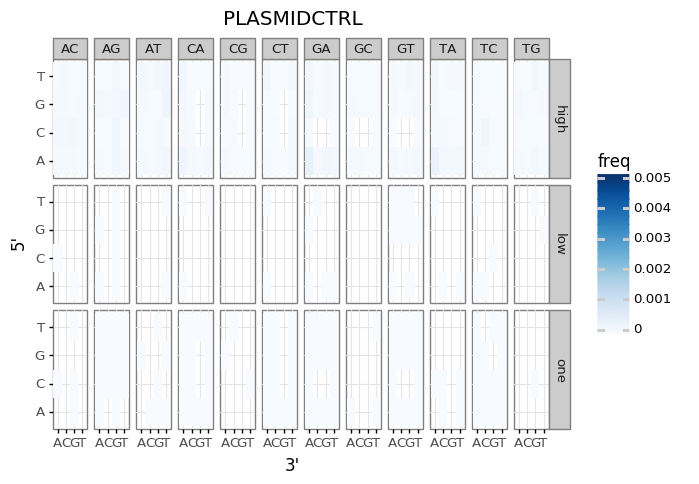

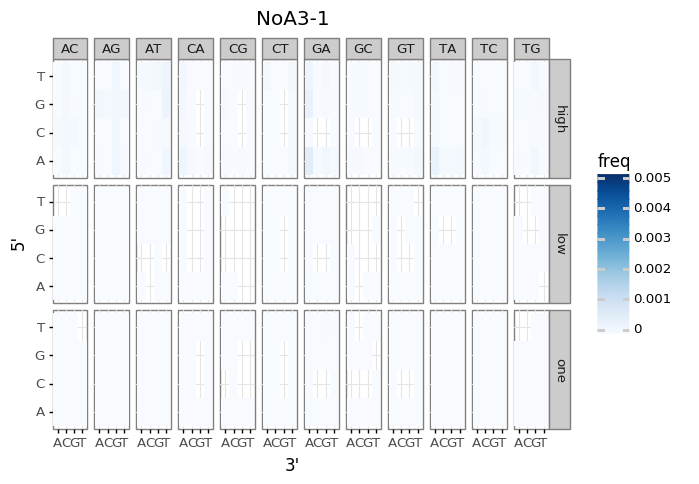

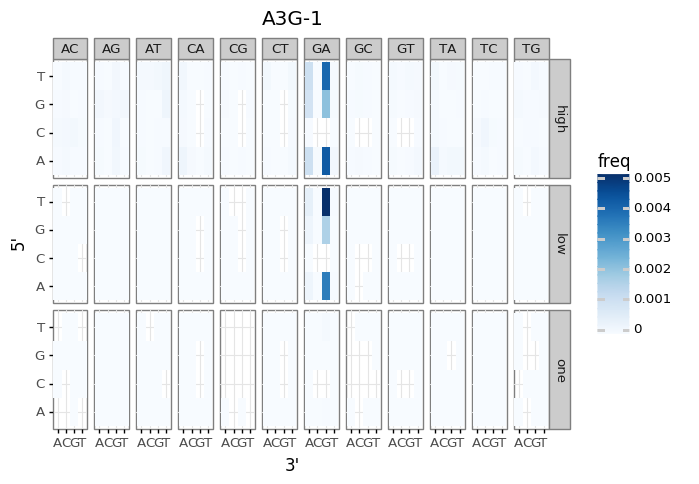

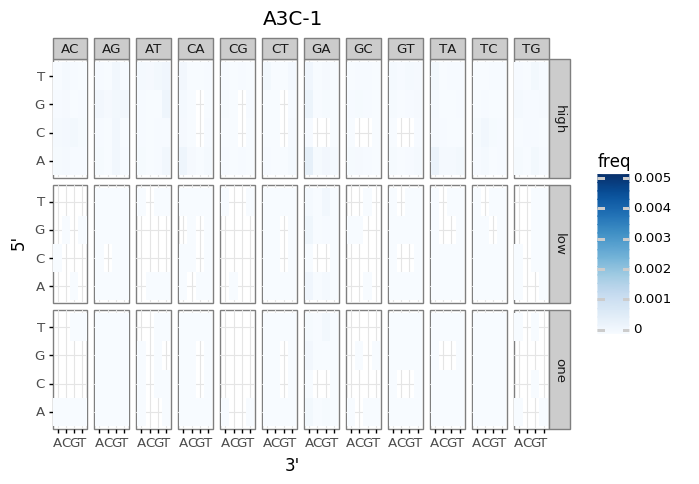

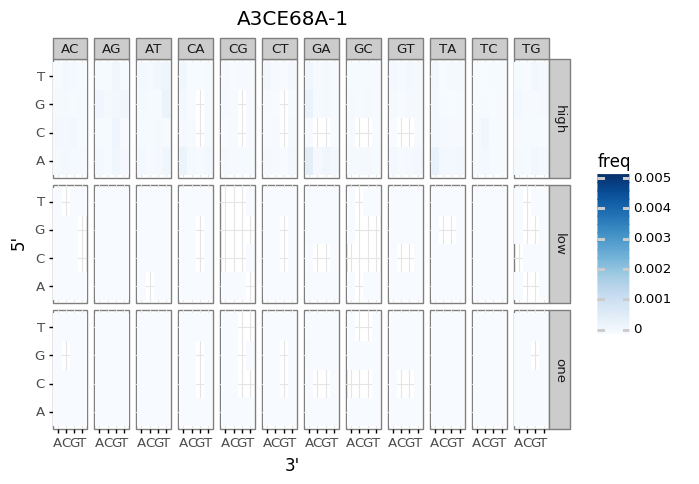

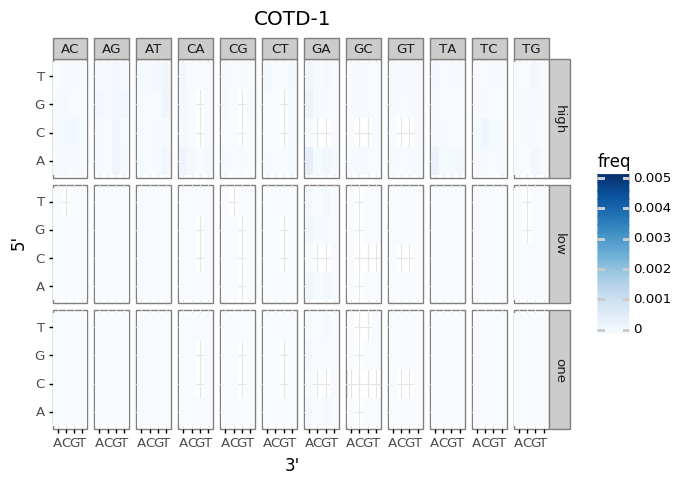

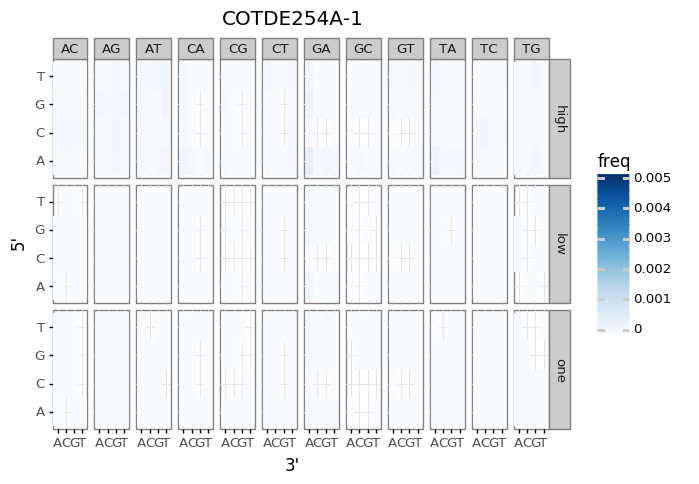

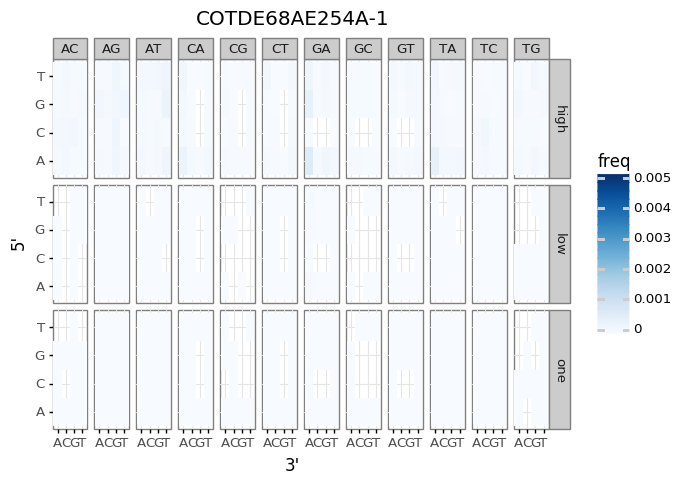

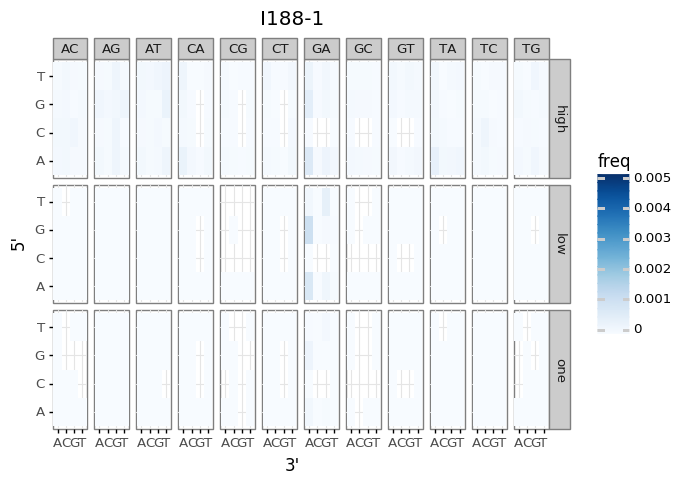

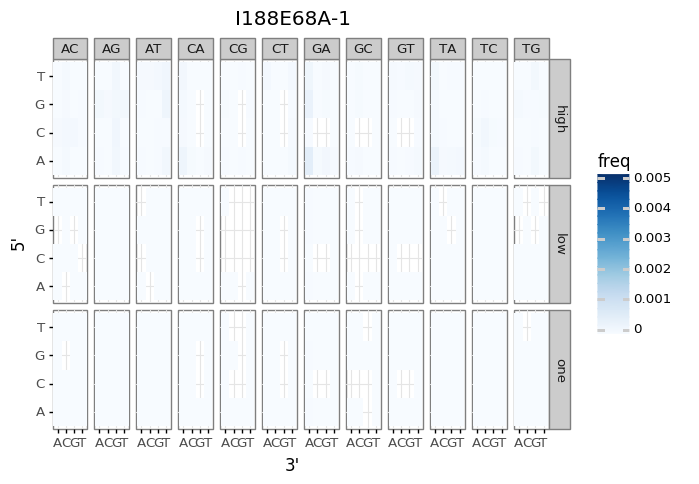

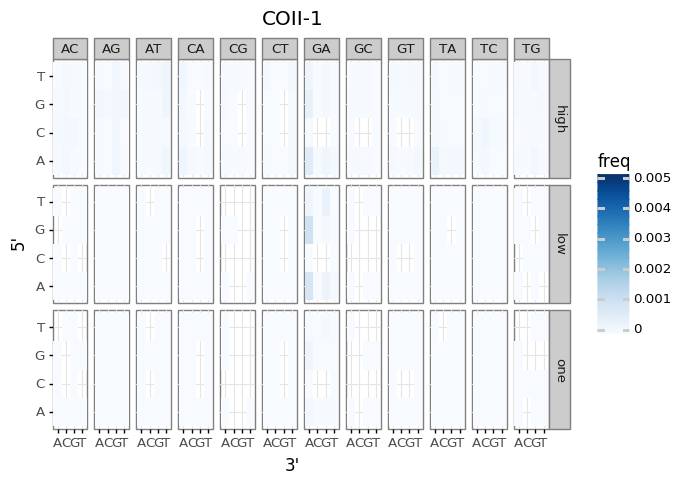

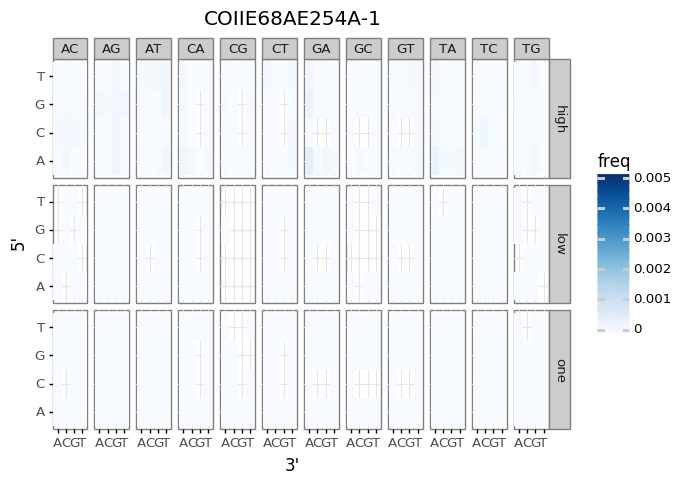

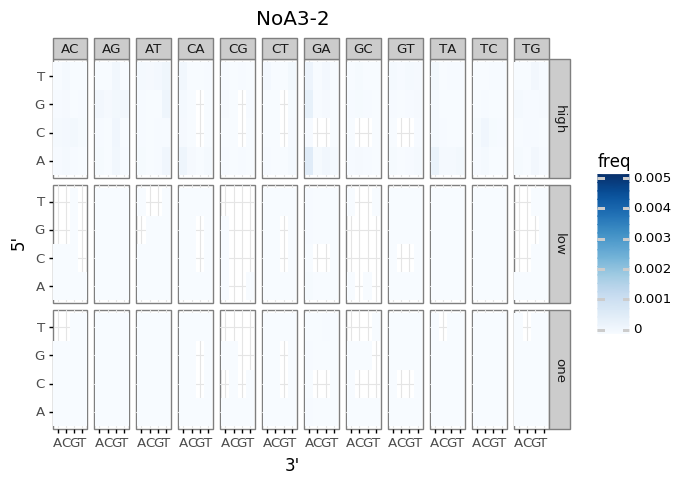

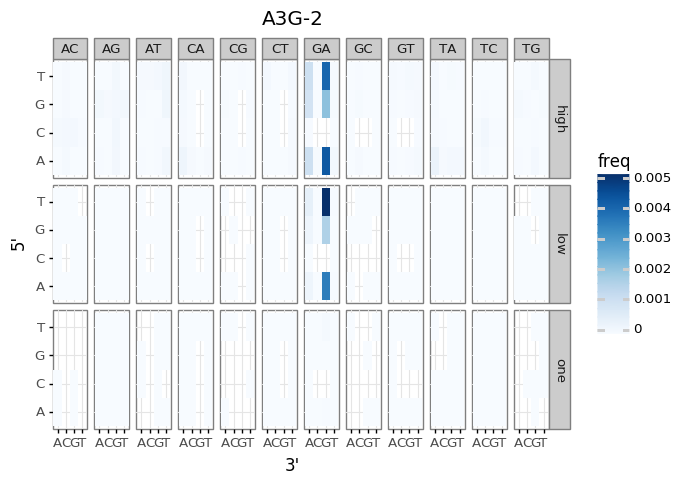

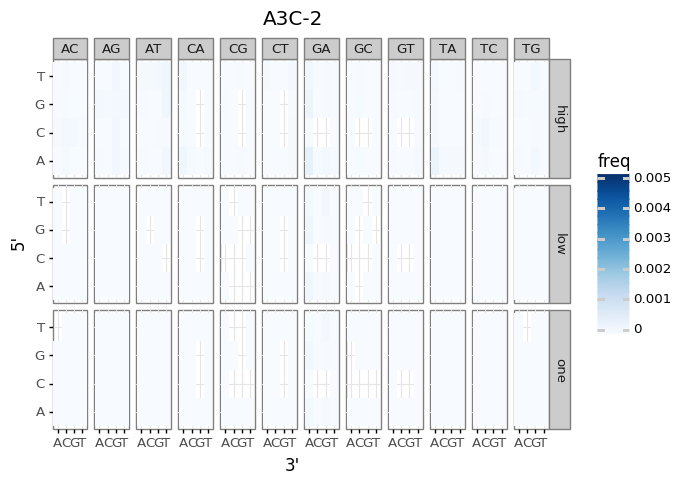

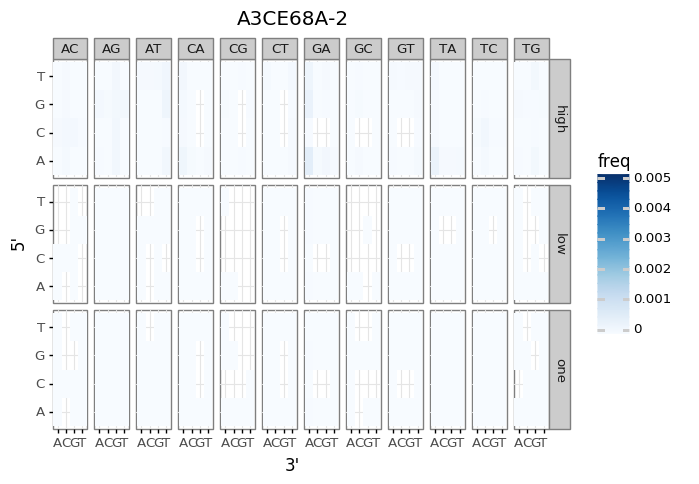

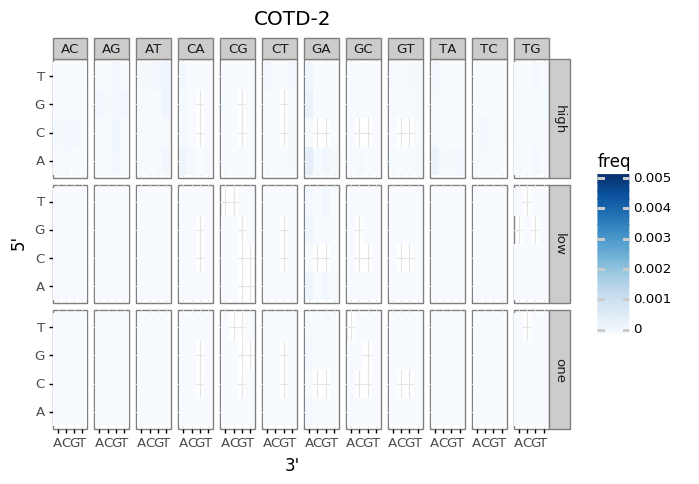

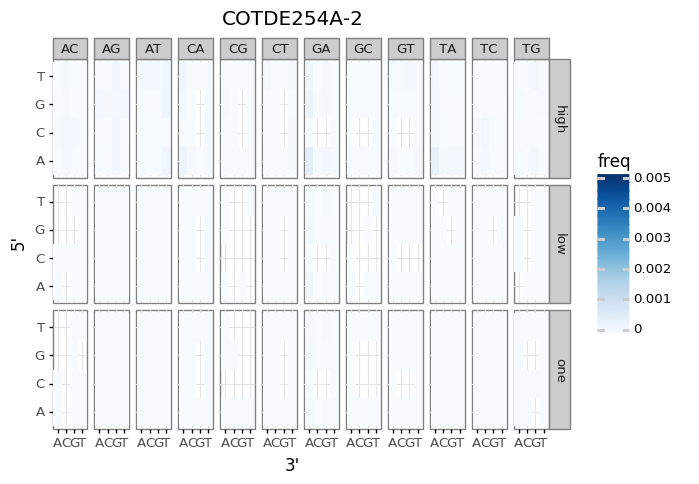

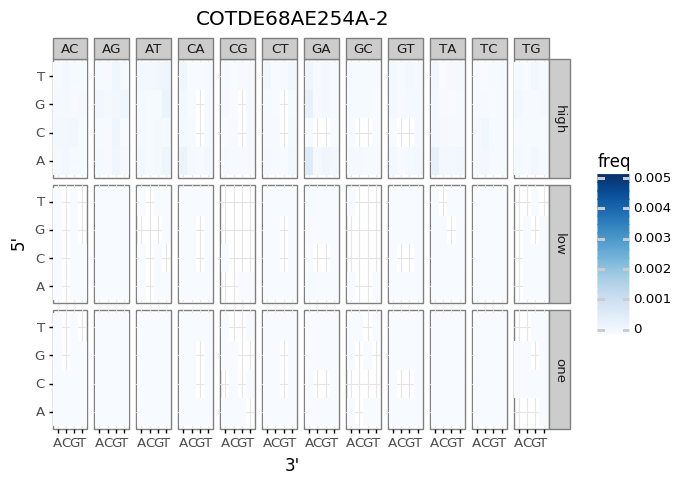

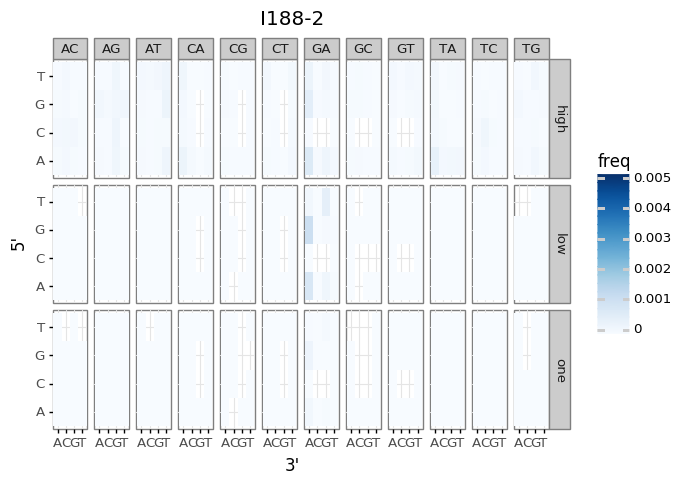

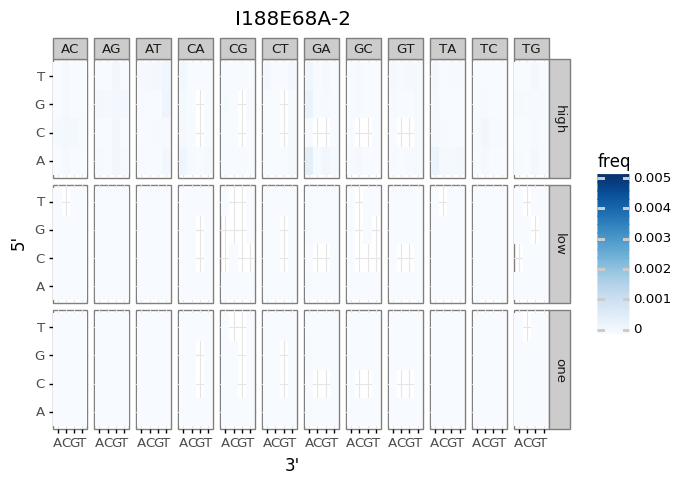

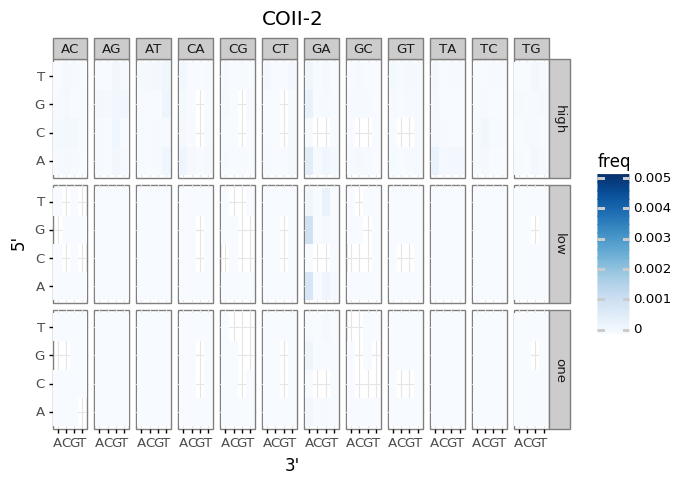

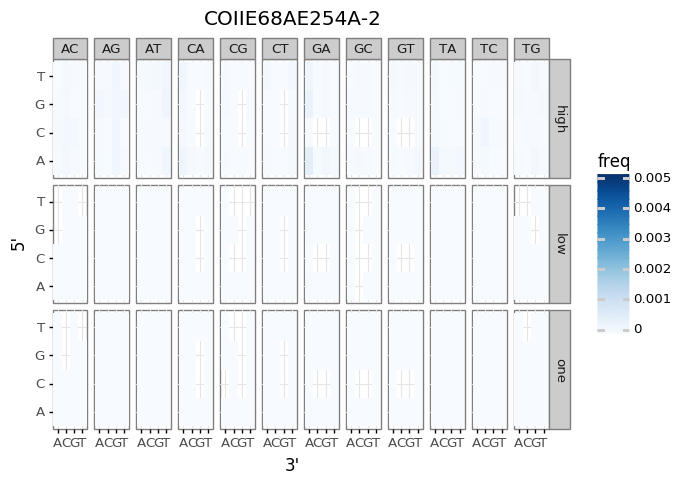

In [51]:
for sample in df_samplenames:
    print(sample)
    sample_df = mutinfo_dfs[sample]
    one_sub = sample_df[sample_df['n_subs'] == 1]
    low_sub = sample_df[(sample_df['n_subs'] > 1) & 
                            (sample_df['n_subs'] <= 10)]
    high_sub = sample_df[sample_df['n_subs'] > 10]
    sample_subs_counts = pd.DataFrame(columns=['sub',"5'", "3'", 'count', 'freq', 'sub_cat'])
    for sub_df, sub_cat in [(one_sub, 'one'), (low_sub, 'low'), (high_sub, 'high')]:
        sub_info_list = [sub_tup for sub_tups in sub_df['sub_tups'].to_list() for sub_tup in sub_tups]
        sub_info_df = pd.DataFrame(sub_info_list, columns=["5'", 'sub', "3'"])
        sub_info_df_counts = pd.DataFrame({'count' : sub_info_df.groupby( ["sub", "5'", "3'"] ).size()}).reset_index()
        sub_info_df_counts['sub_cat'] = [sub_cat]*len(sub_info_df_counts)
        sample_subs_counts = sample_subs_counts.append(sub_info_df_counts, ignore_index=True)
        sample_subs_counts['count'] = sample_subs_counts['count'].astype('int32')

    sample_subs_counts['freq'] = sample_subs_counts['count'] / nts_retained_no_Ns[sample]
    print(f"Of all, non-N nucleotides {sum(sample_subs_counts['count'])} or {round((sum(sample_subs_counts['count']) / nts_retained_no_Ns[sample])*100, 4)}% are mutated")
    display(sample_subs_counts.sort_values(['count'], ascending=False).head())
    heat_map = (ggplot(sample_subs_counts, aes("3'", "5'", fill='freq')) + 
                geom_tile() +
                scale_fill_cmap(name='Blues', limits=(0, 0.005)) +
                facet_grid(['sub_cat', 'sub'], labeller='label_value')+
                labs(title=f"{sample}")              
               )
    
    _heat_map = heat_map.draw()

## Parse bcinfo files into codon variant tables
I will use [dms_tools2.utils.barcodeInfoToCodonVariantTable](https://jbloomlab.github.io/dms_tools2/dms_tools2.utils.html#dms_tools2.utils.barcodeInfoToCodonVariantTable) to parse the /codoncounts/(sample)_bcinfo.txt.gz. files into codon variant tables. 


# New plan:
Alternatively, the /codoncounts/(sample)_bcinfo.txt.gz files (viewed at the end of this notebook) output by bcsubamp could be directly parsed using getSubstitions. 

In [14]:
trimmedrefseq = "CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATAGGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCC"
samplenames2 = ["PLASMIDCTRL", "NoA3-1", "A3G-1", "A3C-1", "A3CE68A-1", "COTD-1", "COTDE254A-1", "COTDE68AE254A-1", "I188-1", "I188E68A-1", "COII-1", "COIIE68AE254A-1", "NoA3-2", "A3G-2", "A3C-2", "A3CE68A-2", "COTD-2", "COTDE254A-2", "COTDE68AE254A-2", "I188-2", "I188E68A-2", "COII-2", "COIIE68AE254A-2"]
samplebcinfofiles = []
for name in samplenames2:
    templist=[]
    templist.append("{0}/{1}".format(countsdir, name))
    samplebcinfofiles.append(templist)
bcinfo_dict = {}

# Create a zip object from two lists
zipbObj = zip(samplenames2, samplebcinfofiles)
 
# Create a dictionary from zip object
bcinfo_dict = dict(zipbObj)

bcinfo_dict

{'PLASMIDCTRL': ['./results_1and1b/codoncounts/PLASMIDCTRL'],
 'NoA3-1': ['./results_1and1b/codoncounts/NoA3-1'],
 'A3G-1': ['./results_1and1b/codoncounts/A3G-1'],
 'A3C-1': ['./results_1and1b/codoncounts/A3C-1'],
 'A3CE68A-1': ['./results_1and1b/codoncounts/A3CE68A-1'],
 'COTD-1': ['./results_1and1b/codoncounts/COTD-1'],
 'COTDE254A-1': ['./results_1and1b/codoncounts/COTDE254A-1'],
 'COTDE68AE254A-1': ['./results_1and1b/codoncounts/COTDE68AE254A-1'],
 'I188-1': ['./results_1and1b/codoncounts/I188-1'],
 'I188E68A-1': ['./results_1and1b/codoncounts/I188E68A-1'],
 'COII-1': ['./results_1and1b/codoncounts/COII-1'],
 'COIIE68AE254A-1': ['./results_1and1b/codoncounts/COIIE68AE254A-1'],
 'NoA3-2': ['./results_1and1b/codoncounts/NoA3-2'],
 'A3G-2': ['./results_1and1b/codoncounts/A3G-2'],
 'A3C-2': ['./results_1and1b/codoncounts/A3C-2'],
 'A3CE68A-2': ['./results_1and1b/codoncounts/A3CE68A-2'],
 'COTD-2': ['./results_1and1b/codoncounts/COTD-2'],
 'COTDE254A-2': ['./results_1and1b/codoncounts/C

In [9]:
#we must use a "wildtype" reference sequnce that is the same length as the sequencing?
#below is the sequence in "./data/Trimmed_Bru_Pol.fasta"
trimmedrefseq = "CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATAGGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCC"
variants = barcodeInfoToCodonVariantTable(bcinfo_dict, trimmedrefseq)

In [13]:
#variants_nt = dms_variants.codonvarianttable()

AttributeError: 'CodonVariantTable' object has no attribute 'n'

In [33]:
import matplotlib
import matplotlib.pyplot as plt
plt.ion()

from IPython.display import display

from epistasis.pyplot import nonlinear



In [36]:
p = variants.plotMutFreqs(variant_type='all', mut_type='codon', heightscale=1.9)
_ = p.draw()

TypeError: Concatenation requires list-likes containing only strings (or missing values). Offending values found in column integer

In [35]:
p = variants.plotNumMutsHistogram('codon', samples=None)
display(p)

TypeError: Concatenation requires list-likes containing only strings (or missing values). Offending values found in column integer